## Summary

This notebook replicates the experiments in the ICWSM'17 paper entitled "Identifying Leading Indicators of Product Recalls from Online Reviews using Positive Unlabeled Learning and Domain Adaptation," by Shreesh Kumara Bhat and Aron Culotta. A full version of the paper is here: <https://arxiv.org/abs/1703.00518>

This notebook first downloads all the required data files from Dropbox into the local folder `data` (~194M).





In [1]:
from collections import Counter, defaultdict
from datetime import datetime
import gzip
from IPython.display import display
from itertools import groupby, cycle
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from sklearn.feature_selection import chi2, f_classif
from scipy.sparse import hstack as sp_hstack
from scipy.sparse import vstack as sp_vstack
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import scale
from tabulate import tabulate
import urllib.request

%matplotlib inline

PATH = 'data'
complaints_file = PATH + os.path.sep + 'complaints.csv'
reviews_file = PATH + os.path.sep + 'reviews.json.gz'
test_file = PATH + os.path.sep + 'test.csv'
recalls_file = PATH + os.path.sep + 'recalls.csv'
recalled_asins_file = PATH + os.path.sep + 'recalled_asins.txt'

# Formatting for matplotlib
plt.rcParams["xtick.labelsize"] = "16"
plt.rcParams["ytick.labelsize"] = "16"


/usr/lib64/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Download data from Dropbox.

In [2]:
def download_data(path):
    """
    Download any required files if not already present.
    """
    files = [('https://www.dropbox.com/s/k18rpimaif014b0/complaints.csv?dl=1', 'complaints.csv'),
             ('https://www.dropbox.com/s/jwr77xpsa7d1w4b/recalls.csv?dl=1', 'recalls.csv'),
             ('https://www.dropbox.com/s/ww0bmhf4iw84a33/reviews.json.gz?dl=1', 'reviews.json.gz'),
             ('https://www.dropbox.com/s/mtppphs0bml727a/test.csv?dl=1', 'test.csv'),
             ('https://www.dropbox.com/s/53g3hqfodeb52xi/recalled_asins.txt?dl=1', 'recalled_asins.txt')]

    if not os.path.exists(path):
        os.makedirs(path)
        
    for url, name in files:
        if not os.path.exists(path + os.path.sep + name):
            print('fetching %s' % name)
            urllib.request.urlretrieve(url, path + os.path.sep + name)        

download_data(PATH)

fetching complaints.csv
fetching recalls.csv
fetching reviews.json.gz
fetching test.csv
fetching recalled_asins.txt


## Read and explore review data.

In [3]:
def parse_all_reviews(filename):
    """
    Parse all reviews into a sparse document x term csr_matrix.
    """
    
    def iter_reviews(filename):
        i = 0
        for line in gzip.open(filename, 'rt'):
            js = json.loads(line)
            yield js['reviewText'], js['asin'], js['reviewTime'], js['overall'], js['reviewText']
            i += 1
            if i % 100000 == 0:
                print('read %d reviews' % i)
                      
    records = []
    vec = CountVectorizer(min_df=50, ngram_range=(1,2), max_df=.95, binary=True)
    X = vec.fit_transform(r[0] for r in iter_reviews(filename) if 
                      not records.append(r[1:]))
    return X, vec, pd.DataFrame(records, columns=['ASIN', 'review_time', 'review_score', 'reviewText'])

X_reviews, vec, reviews_df = parse_all_reviews(reviews_file)
print('X_reviews has shape %s' % str(X_reviews.shape))
reviews_df.head()

read 100000 reviews
read 200000 reviews
read 300000 reviews
read 400000 reviews
read 500000 reviews
read 600000 reviews
read 700000 reviews
read 800000 reviews
read 900000 reviews
X_reviews has shape (915446, 136160)


,ASIN,review_time,review_score,reviewText
0,0188399313,"05 27, 2013",5.0,"They work very well. Easy to clean, we wash th..."
1,0188399399,"04 9, 2013",5.0,it came early and was not disappointed. i love...
2,0188399518,"02 14, 2014",4.0,I ended up with a variety of different brands ...
3,0188399518,"07 8, 2013",3.0,"These flannel wipes are OK, but in my opinion ..."
4,0316967297,"09 6, 2013",4.0,"Cute quilt, the colors are perfect and my litt..."


In [4]:
# reformat date string.
def format_dates(reviews_df):
    new_dates = []
    for x in reviews_df['review_time']:
        parts = [x.replace(',', '') for x in x.split()]
        new_dates.append('%s-%s-%s' % (parts[2], parts[0].zfill(2), parts[1].zfill(2)))
    print(new_dates[:10])
    reviews_df['review_time'] = new_dates
    
format_dates(reviews_df)

['2013-05-27', '2013-04-09', '2014-02-14', '2013-07-08', '2013-09-06', '2013-03-22', '2012-03-07', '2013-04-23', '2012-11-26', '2013-08-02']


In [5]:
# Number of reviews by score.
pd.value_counts(reviews_df.review_score)

5.0    534132
4.0    165123
3.0     82931
1.0     76938
2.0     56322
Name: review_score, dtype: int64

In [6]:
# Exploring length distribution of reviews.
lengths = [len(x.split()) for x in reviews_df['reviewText']]
lengths = [l for l in lengths if l != 0]
print(np.median(lengths))
pd.DataFrame(lengths).describe()

55.0


,0
count,915104.000000
mean,81.951987
std,87.139825
min,1.000000
25%,31.000000
50%,55.000000
75%,100.000000
max,4546.000000


## Read and explore complaints data.

In [7]:
def parse_complaints(complaints_file, vec):
    """
    Parse all the CPSC complaints, using the same vectorizer fit on the Amazon review data.
    """
    complaints_df = pd.read_csv(complaints_file)
    X = vec.transform(complaints_df['Incident Description'])
    vec.features = np.array(vec.get_feature_names())
    return X, complaints_df

X_complaints, complaints_df = parse_complaints(complaints_file, vec)
print('complaints feature matrix has shape %s' % str(X_complaints.shape))
complaints_df.head()

complaints feature matrix has shape (2010, 136160)


,Report No.,Report Date,Sent to Manufacturer / Importer / Private Labeler,Publication Date,Category of Submitter,Product Description,Product Category,Product Sub Category,Product Type,Product Code,...,Submitter Has Product,Product Was Damaged Before Incident,Damage Description,Damage Repaired,Product Was Modified Before Incident,Have You Contacted The Manufacturer,If Not Do You Plan To,Answer Explanation,Company Comments,Associated Report Numbers
0,20160509-F1AD6-2147419650,5/9/2016,5/17/2016,6/8/2016,Consumer,Munchkin pacifier clip,Baby,Nursery Equipment & Supplies,Pacifiers or Teething Rings,1525,...,NaN,Yes,NaN,NaN,NaN,Yes,Yes,NaN,NaN,NaN
1,20160506-66663-2147419715,5/6/2016,5/16/2016,5/31/2016,Consumer,"Baby Einstein Bouncer, Multicolor, has a piano...",Baby,Nursery Equipment & Supplies,Baby Bouncer Seats (Excl. Jumpers),1558,...,NaN,Yes,NaN,NaN,NaN,Yes,Yes,I thought I was contacting them. the link on t...,NaN,NaN
2,20160429-84BCB-2147419859,4/29/2016,5/9/2016,5/31/2016,Consumer,Luxury teether toys for happy baby teething.\r...,Baby,Nursery Equipment & Supplies,Pacifiers or Teething Rings,1525,...,NaN,Yes,NaN,NaN,NaN,Yes,Yes,I still have the product and plan on reaching ...,NaN,NaN
3,20160505-69C2D-2147419760,5/5/2016,5/13/2016,5/27/2016,Consumer,"Graco Lauren Classic Crib, model #2354497, pro...",Baby,Nursery Equipment & Supplies,Cribs,1543,...,NaN,Yes,NaN,NaN,NaN,Yes,NaN,I still have this product. Graco said they are...,NaN,NaN
4,20160504-C585C-2147419771,5/4/2016,5/12/2016,5/26/2016,Consumer,Baby swing savanah model CMH84,Baby,Nursery Equipment & Supplies,Portable Baby Swings (For Home Use),1553,...,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Tryin to figure out who to contact about incid...,NaN,NaN


In [8]:
# Frequency of each victim severity.
complaints_df['(Primary) Victim Severity'].value_counts()

Incident, No Injury                                       909
Injury, First Aid Received by Non-Medical Professional    299
Injury, No First Aid or Medical Attention Received        298
Injury, Seen by Medical Professional                      194
Unspecified                                                87
Injury, Emergency Department Treatment Received            82
Injury, Level of care not known                            66
Injury, Hospital Admission                                 30
No Incident, No Injury                                     26
Death                                                      19
Name: (Primary) Victim Severity, dtype: int64

In [9]:
# Frequency of product types in complaint data.
complaints_df['Product Type'].value_counts()

Cribs                                                           407
Bassinets or Cradles                                            258
Diapers                                                         209
Pacifiers or Teething Rings                                     186
Baby Exercisers                                                 132
High Chairs                                                     116
Night-lights                                                    101
Baby Gates or Barriers                                           74
Playpens                                                         57
Infant & Toddler Play Ctrs, Excl Jumpers,bouncers&exercisers     55
Baby Bouncer Seats (Excl. Jumpers)                               55
Attached Highchair                                               49
Portable Baby Swings (For Home Use)                              46
Baby Mattresses or Pads                                          43
Baby Walkers or Jumpers                         

In [10]:
# complaints by year
sorted(Counter([d[-4:] for d in complaints_df['Report Date']]).items())

[('2011', 502),
 ('2012', 447),
 ('2013', 432),
 ('2014', 332),
 ('2015', 240),
 ('2016', 57)]

In [11]:
# Distribution of number of words per complaint.
lengths = [len(x.split()) for x in complaints_df['Incident Description']]
print(np.median(lengths))
display(pd.DataFrame(lengths).describe())

98.0


,0
count,2010.000000
mean,124.513930
std,114.461285
min,4.000000
25%,56.000000
50%,98.000000
75%,159.000000
max,1683.000000


 ## Read labeled data.

In [12]:
def parse_test_data(filename, vec):
    """
    Parse labeled Amazon reviews using the same
    vectorizer fit to the unlabeled Amazon reviews.
    """
    df = pd.read_csv(test_file)
    df.dropna(inplace=True)
    df.rename(columns={'Review Text': 'text'}, inplace=True)
    X = vec.transform(t for t in df['text'])
    return X, df

X_test, test_df = parse_test_data(test_file, vec)
print('X_test has shape %s' % str(X_test.shape))
test_df.head()

X_test has shape (448, 136160)


,label,ASIN,text
0,1,B002NU50LO,We purchased this dresser 2 years ago and were...
1,1,B004C43JJ4,I just got my order today and put my six month...
2,1,B00020L78M,"I personally didn't buy this gate, specificall..."
3,1,B00HVSVPQ2,I bought it for my son who is only six months ...
4,1,B0091DHACS,"These are currently being recalled, and the mu..."


In [13]:
# Label distribution
display(test_df['label'].value_counts())

0    351
1     97
Name: label, dtype: int64

## Read recalled amazon products.

In [14]:
# This file contains manually labeled instances
# of recall / product pairs. The label indicates whether the match is valid.
recalls_df = pd.read_csv(recalls_file, sep='\t')
recalls_df.head()

,label,RecallNumber,RecallName,AmazonTitle,AmazonAsin,NumReviews,Score,RecallTitle,RecallDescription,RecallDate
0,1,8263,Munchkin Deluxe Bottle and Food Warmers with P...,Munchkin Deluxe Bottle And Food Warmer With P...,B00007C65S,32,9,Baby Bottle and Food Warmers Recalled by Munch...,Baby Bottle and Food Warmers Recalled by Munch...,2008-04-08T00:00:00
1,1,11056,The First Years American Red Cross Cabinet Swi...,The First Years American Red Cross Cabinet And...,B001ODU26E,4,8,The First Years® Recalls American Red Cross® C...,This recall involves The First Years American ...,2010-12-02T00:00:00
2,0,14072,"Zoom Car Seat Adapter, Adapter clips can loose...",Phil&amp;Teds Car Seat Adapter For Peg Perego ...,B003BNTNLA,5,7,Joovy Recalls Zoom Car Seat Stroller Adapter d...,This recall involves all Joovy’s Zoom gray met...,2013-12-30T00:00:00
3,0,13061,Dream On Me Ultra 2 in 1 Infant Bath Tub; Todd...,Dream On Me 2 in 1 Baby Tunes Musical Activity...,B005GU18FU,11,7,Dream On Me Recalls Bath Seats Due to Drowning...,The recall includes all Dream On Me bath seats...,2012-12-06T00:00:00
4,0,13061,Dream On Me Ultra 2 in 1 Infant Bath Tub; Todd...,Dream On Me 2 In 1 Baby Bather and Changing St...,B003ZUXWNE,7,7,Dream On Me Recalls Bath Seats Due to Drowning...,The recall includes all Dream On Me bath seats...,2012-12-06T00:00:00


In [15]:
# Number of unique recalls.
len(set(recalls_df[recalls_df.label==1]['RecallNumber']))

47

In [16]:
# Number of unique recalled ASINs
recalled_asins = set(l.strip() for l in open(recalled_asins_file))
print('%d recalled ASINs' % len(recalled_asins))

137 recalled ASINs


## Classification Experiments

Here we perform classification experiments to evaluate the effectiveness of the proposed domain adaptation method for positive unlabeled learning.

In [17]:
class Data:
    """
    Container for all the data.
    """
    def __init__(self, X_complaints, complaints_df,
                 X_test, test_df,
                 X_reviews, reviews_df,
                 recalls_df, recalled_asins, vec):
        self.X_complaints = X_complaints
        self.complaints_df = complaints_df
        self.X_test = X_test
        self.test_df = test_df
        self.X_reviews = X_reviews
        self.reviews_df = reviews_df
        self.recalls_df = recalls_df
        self.recalled_asins = recalled_asins
        self.vec = vec

data = Data(X_complaints, complaints_df,
            X_test, test_df,
            X_reviews, reviews_df,
            recalls_df, recalled_asins, vec)

In [18]:
class Evaluator(object):
    """
    Evaluation metrics.
    """
    def __init__(self, data):
        self.data = data
        
    def evaluate(self, model):
        """
        Evaluate on test data.
        """
        model.fit(self.data)
        preds = model.predict(self.data)
        probas = model.predict_proba(self.data)
        truths = np.array(self.data.test_df['label'])
        f1 = f1_score(truths, preds)
        recall = recall_score(truths, preds)
        precision = precision_score(truths, preds)
        roc_auc = roc_auc_score(truths, probas, average=None)
        precisions, recalls, pr_auc, pr_at_k = self.evaluate_recalls(model)
        return {'f1': f1, 'roc_auc': roc_auc, 'pr_auc': pr_auc, 'recall': recall, 'precision': precision, 'pr_at_k': pr_at_k}
        
    def evaluate_recalls(self, model):
        """
        Evaluate against recalled products.
        """
        asin2recall_score = model.score_asin_recalls(self.data)
        asins = set(self.data.reviews_df.ASIN)
        probas = np.array([asin2recall_score[x] for x in asins])
        truths = np.array([1 if x in data.recalled_asins else 0 for x in asins])
        roc_auc = roc_auc_score(truths, probas)
        prec, recall, thresholds = precision_recall_curve(truths, probas)
        prec = self._interpolate(prec)
        pr_auc = auc(recall, prec)
        # evaluate precision at number of true positives.
        rank = sum(truths)
        pred = np.argsort(probas)[::-1][:rank]
        correct = len(set(pred) & set(np.where(truths==1)[0]))
        pr_at_k = correct / rank
        return prec, recall, pr_auc, pr_at_k
        
    def plot_prec_recalls(self, results):
        plt.figure()
        for r in results:
            plt.plot(r['prcurve'][1], r['prcurve'][0], '.-', label=r['model'])
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.legend(loc="best")
        plt.xlim(-.01, .2)
        plt.show()
       
    def _interpolate(self, prec):
        p_temp = prec[0]
        n = len(prec)
        for i in range(n):
            if prec[i] < p_temp:
                prec[i] = p_temp
            else:
                p_temp = prec[i]
        return prec
    
    
    def confusion(self, truths, preds, labels):
        m = confusion_matrix(truths, preds)
        m = np.vstack((labels, m))
        m = np.hstack((np.matrix([''] + list(labels)).T, m))
        return tabulate(m.tolist(), headers='firstrow')
    
    def top_terms(self, model, n=10):
        """
        Print top terms per class.
        """
        coef = model.get_coef()
        print('\n\nTOP FEATURES:')
        coefs = [-coef[0], coef[0]]
        for li, label in enumerate(model.clf.classes_):
            print('\nCLASS %s' % label)
            coef = coefs[li]
            top_coef_ind = np.argsort(coef)[::-1][:n]
            top_coef_terms = self.data.vec.features[top_coef_ind]
            top_coef = coef[top_coef_ind]
            print('\n'.join(['%s\t%.3f' % (term, weight)
                             for term, weight in zip(top_coef_terms, top_coef)]))

            
    def top_error_terms(self, model):
        """
        Print top terms appearing in incorrectly labeled documents.
        """
        truths = np.array(self.data.test_df['label'])
        preds = model.predict(self.data)
        X = self.data.X_test
        data = np.array(self.data.test_df['text'])
        print('\n\nERROR ANALYSIS:\n')
        for label in model.clf.classes_:
            print('\nincorrectly labeled %s' % label)
            iserror = np.zeros(len(truths))
            ind = [i for i, (t, p) in enumerate(zip(truths, preds)) if t != p and p == label]
            iserror[ind] = 1
            corrs, _ = f_classif(X, iserror)
            corrs = np.nan_to_num(corrs)
            pos_mask, pos_counts, neg_counts = self.get_pos_mask(X, iserror)
            corrs *= pos_mask
            # ignore features from only 1 incorrect instance.
            corrs *= np.sign(X.sign()[np.where(iserror == 1)].sum(axis=0).A1 - 1)
            for fidx in np.argsort(corrs)[::-1][:5]:
                print('\n\t%s (%d incorrect, %d correct) corr=%.4f' %
                      (self.data.vec.features[fidx], pos_counts[fidx], neg_counts[fidx], corrs[fidx]))
                matches = []
                for midx in range(X.shape[0]):
                    if X[midx, fidx] > 0 and iserror[midx] == 1:
                        matches.append(midx)
                for m in matches[:3]:
                    print('\t\t' + data[m])
    
    def get_pos_mask(self, X, y, reg=1):
        """Get mask for indices that are more associated with class 1 than class 0."""
        pos_counts = X.sign()[np.where(y == 1)].sum(axis=0).A1
        neg_counts = X.sign()[np.where(y == 0)].sum(axis=0).A1
        posp = (1. + pos_counts) / pos_counts.sum()
        negp = (1. + neg_counts) / neg_counts.sum()
        diffs = posp - negp
        diffs = np.array([1 if v > 0 else -1 for v in diffs])
        return np.array(diffs), pos_counts, neg_counts
    
    
def average_results(results):
    avg = {}
    for k in results[0].keys():
        vals = [r[k] for r in results]
        avg[k] = np.mean(vals)
        avg[k+'_se'] = np.std(vals) / math.sqrt(len(vals))
    return avg
        
def evaluate_models(models, data, seeds=[42, 11111, 12345678, 919191, 5555]):
    """
    Evaluate all models using multiple seeds and average the results.
    """
    evaluator = Evaluator(data)
    all_results = []
    for m in models:
        results = []
        for seed in seeds:
            m.seed = seed
            name = str(m)
            print('Evaluating %s' % name)
            results.append(evaluator.evaluate(m))
        r = average_results(results)
        r['model'] = m
        all_results.append(r)
    df = pd.DataFrame(all_results).sort_values('f1', ascending=False)
    mdl = df['model']
    df.drop(labels=['model'], axis=1,inplace = True)
    df.insert(0, 'model', mdl)
    return df

In [19]:
# Here we implement the different classification models.


# Some helper functions.
def _count(probs):
    return len(np.where(np.array(probs) >= .5)[0])

def _count_mean(probs):
    return len(np.where(np.array(probs) >= .5)[0]) / len(probs)

def _mean(probs):
    return np.mean(probs)

def _max(probs):
    return max(probs)

class Model(object):
    """
    Abstract base class.
    """
    def __init__(self, C=1):
        self.C = C
        self.make_clf()        
        
    def fit(self, data):
        pass

    def predict(self, data):
        return self.clf.predict(data.X_test)

    def predict_proba(self, data):
        """
        Predict the probability of recall on each test example.
        """
        return self.clf.predict_proba(data.X_test)[:,1]

    def predict_reviews(self, data):
        return self.clf.predict(data.X_reviews)

    def predict_proba_reviews(self, data):
        return self.clf.predict_proba(data.X_reviews)[:,1]

    def score_asin_recalls(self, data, aggregator_fn=_count):
        """
        Compute a score indicating the likelihood that each product
        should be recalled, based on the classification of each review.
        """
        probas = self.predict_proba_reviews(data)

        preds = {}
        for asin, group in groupby([x for x in zip(data.reviews_df['ASIN'], probas)],
                                   key=lambda x: x[0]):
            preds[asin] = aggregator_fn([x[1] for x in group])
        return preds
        
    def make_clf(self):
        self.clf = LogisticRegression(class_weight='balanced', C=self.C)
        
    def get_coef(self):
        return self.clf.coef_

    
class RandomNegativeSamples(Model):
    """
    Sample n_neg random examples from the unlabeled data
    and pretend they are negative.
    """
    def __init__(self, n_neg=-1, seed=42, C=1):
        super().__init__(C=C)
        self.seed = seed
        self.n_neg = n_neg
        
    def fit(self, data):
        random.seed(self.seed)
        if self.n_neg == -1:
            neg = data.X_complaints.shape[0]
        else:
            neg = self.n_neg
        samplei = random.sample(range(data.X_reviews.shape[0]), neg)
        self.neg_sample_idx = samplei
        X = sp_vstack((data.X_complaints, data.X_reviews[samplei]))
        y = np.concatenate(([1] * data.X_complaints.shape[0],
                            [0] * neg))
        self.clf.fit(X, y)
        
    def __str__(self):
        return "RandomNegSamples(C=%g,n=%d)" % (self.C, self.n_neg)
    

class RandomNegativeSamplesThreshold(Model):
    """
    Sample n_neg random examples from the unlabeled data
    with review >= threshold and pretend they are negative.
    """
    
    def __init__(self, threshold=4.5, n_neg=-1, seed=42, C=1):
        super().__init__(C=C)
        self.seed = seed
        self.threshold = threshold
        self.n_neg = n_neg
        
    def fit(self, data):
        if self.n_neg == -1:
            neg = data.X_complaints.shape[0]
        else:
            neg = self.n_neg
        random.seed(self.seed)
        pos_reviews = list(np.where(data.reviews_df['review_score'] >= self.threshold)[0])
        samplei = random.sample(pos_reviews, neg)
        self.neg_sample_idx = samplei
        X = sp_vstack((data.X_complaints, data.X_reviews[samplei]))
        y = np.concatenate(([1] * data.X_complaints.shape[0],
                            [0] * neg))
        self.clf.fit(X, y)
        
    def __str__(self):
        return "RandomNegSamplesThresh(C=%d, nneg=%d, t=%.1f)" % (self.C, self.n_neg, self.threshold)

    
class RandomNegativeSamplesThresholdInformedPrior(Model):
    """
    Sample n_neg random examples from the unlabeled data
    and pretend they are negative.
    Also implement the informed prior approach, described
    in the paper.
    """

    def __init__(self, threshold=4.5, n_neg=-1, seed=42, C=1000):
        super().__init__(C=C)
        self.seed = seed
        self.threshold = threshold
        self.n_neg = n_neg
        
    def fit(self, data):
        if self.n_neg == -1:
            neg = data.X_complaints.shape[0]
        else:
            neg = self.n_neg
        random.seed(self.seed)
        pos_reviews = list(np.where(data.reviews_df['review_score'] >= self.threshold)[0])
        samplei = random.sample(pos_reviews, neg)
        self.neg_sample_idx = samplei
        X = sp_vstack((data.X_complaints, data.X_reviews[samplei]))
        y = np.concatenate(([1] * data.X_complaints.shape[0],
                            [0] * neg))
        self.clf.fit(X, y)
        
        # Now, predict on test set, compute priors and refit.
        predictions = self.clf.predict(data.X_reviews)
        nneg = len(np.where(predictions==0)[0])
        npos = len(np.where(predictions==1)[0])
        ## get positive/negative coefficients.
        pos_coef_i = np.where(self.clf.coef_[0] > 0)
        neg_coef_i = np.where(self.clf.coef_[0] < 0)

        pos_pct = npos / (nneg + npos)
        ppos_counts = data.X_reviews[np.where(predictions==1)].sum(axis=0).A1
        pneg_counts = data.X_reviews[np.where(predictions==0)].sum(axis=0).A1
        pos_probs = ((1 + ppos_counts) / (2 + ppos_counts + pneg_counts))[pos_coef_i]
        print('pos probs1', pos_probs[:20])
        neg_probs = ((1 + pneg_counts) / (2 + ppos_counts + pneg_counts))[neg_coef_i]
        # Normalize so that pos and neg coef are in similar range.
        pos_probs = pos_probs / pos_probs.sum()
        neg_probs = neg_probs / neg_probs.sum()
        print('pos probs2', pos_probs[:20])

        transform = np.zeros(X.shape[1])
        transform[pos_coef_i] = pos_probs  # pos_probs[pos_coef_i]  
        transform[neg_coef_i] = neg_probs  # neg_probs[neg_coef_i]
        transform *= len(transform) / transform.sum()
        print('mean=', np.mean(transform))
        print('mean2=', np.mean(transform[pos_coef_i]))
        print('pos probs3', transform[pos_coef_i][:20])

        print('transform:', sorted(transform)[:10], sorted(transform)[::-1][:10])
        tops = []
        for i in sorted(pos_coef_i[0], key=lambda x: -transform[x])[:20]:
            tops.append({'term': data.vec.features[i], 'coef': self.clf.coef_[0][i], 'transform': transform[i]})
        display(pd.DataFrame(tops).sort_values('transform', ascending=False))
        # Some debug statements.
        print('hazard transform=', transform[data.vec.vocabulary_['hazard']])
        print('crib transform=', transform[data.vec.vocabulary_['crib']])
        print('pampers transform=', transform[data.vec.vocabulary_['pampers']])
        print('very dangerous transform=', transform[data.vec.vocabulary_['very dangerous']])

        tops = []
        for i in sorted(neg_coef_i[0], key=lambda x: -transform[x])[:20]:
            tops.append({'term': data.vec.features[i], 'coef': self.clf.coef_[0][i], 'transform': transform[i]})
        display(pd.DataFrame(tops).sort_values('transform', ascending=False))
        self.transform = csr_matrix(transform)
        self.clf.fit(X.multiply(self.transform), y)
        
    def predict(self, data):
        return self.clf.predict(data.X_test.multiply(self.transform))

    def predict_proba(self, data):
        """
        Predict the probability of recall on each test example.
        """
        return self.clf.predict_proba(data.X_test.multiply(self.transform))[:,1]

    def predict_reviews(self, data):
        return self.clf.predict(data.X_reviews.multiply(self.transform))

    def predict_proba_reviews(self, data):
        return self.clf.predict_proba(data.X_reviews.multiply(self.transform))[:,1]
        
    def __str__(self):
        return "RandNegSampThreshInfoPrior(C=%g, nneg=%d, t=%.1f)" % (self.C, self.n_neg, self.threshold)

In [20]:
# Collect all models for comparison.
models = [
          RandomNegativeSamples(n_neg=20000, C=1),

          RandomNegativeSamplesThreshold(threshold=3.0, n_neg=20000, C=1),
          RandomNegativeSamplesThreshold(threshold=4.0, n_neg=20000, C=1),
          RandomNegativeSamplesThreshold(threshold=5.0, n_neg=20000, C=1),

          RandomNegativeSamplesThresholdInformedPrior(threshold=3.0, n_neg=20000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=4.0, n_neg=20000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=20000, C=1),

          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=1000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=5000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=10000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=30000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=40000, C=1),
          RandomNegativeSamplesThresholdInformedPrior(threshold=5.0, n_neg=50000, C=1),
         ]

results = evaluate_models(models, data, seeds=[123456, 42, 987987])

Evaluating RandomNegSamples(C=1,n=20000)
Evaluating RandomNegSamples(C=1,n=20000)
Evaluating RandomNegSamples(C=1,n=20000)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=3.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=3.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=3.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=4.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=4.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=4.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=5.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=5.0)
Evaluating RandomNegSamplesThresh(C=1, nneg=20000, t=5.0)
Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=3.0)
pos probs1 [ 0.08571429  0.01005025  0.01612903  0.04819277  0.07142857  0.07079646
  0.03816794  0.03225806  0.03703704  0.02797203  0.02994012  0.03977273
  0.05392157  0.02020202  0.01403509  0.01851852  0.01369863  0.02597403
  0.02409639  0.01010101]
pos probs2 [  1.01988815e-04   1.1958

,coef,term,transform
0,0.000309,safety commission,61.523784
1,0.000702,consumer product,55.231579
2,0.094143,have choked,47.130948
3,0.006806,product safety,45.903579
4,0.362624,cpsc,44.895067
5,0.193792,be recalled,41.799259
6,0.105946,dangerous product,40.503158
7,0.005696,commission,40.193974
8,0.035305,extremely dangerous,30.973003
9,0.005788,seriously injured,28.229474


hazard transform= 12.510975495
crib transform= 1.90864838583
pampers transform= 1.62012632309
very dangerous transform= 19.7466920266


,coef,term,transform
0,-0.054946,super easy,0.756345
1,-0.075466,are great,0.756289
2,-0.046282,cup holders,0.756272
3,-0.065321,so cute,0.756248
4,-0.034513,love love,0.756227
5,-0.060443,are soft,0.756226
6,-0.034254,work great,0.756214
7,-0.022103,really love,0.756213
8,-0.025111,it super,0.756210
9,-0.143647,love that,0.756204


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=3.0)
pos probs1 [ 0.01507538  0.01612903  0.01748252  0.05421687  0.05357143  0.0619469
  0.03053435  0.04444444  0.02797203  0.0239521   0.03977273  0.05882353
  0.03398058  0.01299892  0.03571429  0.01403509  0.01851852  0.03225806
  0.01369863  0.02739726]
pos probs2 [  1.78314965e-05   1.90777839e-05   2.06787168e-05   6.41289363e-05
   6.33654966e-05   7.32721966e-05   3.61167207e-05   5.25698934e-05
   3.30859469e-05   2.83310803e-05   4.70440808e-05   6.95778001e-05
   4.01930011e-05   1.53754204e-05   4.22436644e-05   1.66010190e-05
   2.19041223e-05   3.81555678e-05   1.62030493e-05   3.24060987e-05]
mean= 1.0
mean2= 2.16257425114
pos probs3 [ 1.21396828  1.29881553  1.40780704  4.36589798  4.31392301  4.98837115
  2.45882634  3.57895835  2.25249127  1.92877995  3.20276102  4.73685663
  2.73633951  1.04675862  2.87594867  1.13019737  1.49123264  2.59763106
  1.1031036   2.2062072 ]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.000322,safety commission,63.198062
1,0.000671,consumer product,56.734624
2,0.003853,product safety,46.973828
3,0.091019,have choked,46.851818
4,0.358254,cpsc,45.599379
5,0.197924,be recalled,41.873813
6,0.005214,commission,41.800048
7,0.095590,dangerous product,41.562097
8,0.024793,seriously injured,31.722585
9,0.038375,extremely dangerous,29.605354


hazard transform= 11.9596858041
crib transform= 2.04866652901
pampers transform= 1.77158438096
very dangerous transform= 20.7450701875


,coef,term,transform
0,-0.040329,so cute,0.756491
1,-0.026346,super easy,0.756487
2,-0.102125,are great,0.756431
3,-0.053281,love love,0.756370
4,-0.022434,are soft,0.756368
5,-0.021039,really love,0.756355
6,-0.014006,it super,0.756353
7,-0.072784,great to,0.756342
8,-0.006480,will love,0.756331
9,-0.010272,colors are,0.756311


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=3.0)
pos probs1 [ 0.01612903  0.05120482  0.05357143  0.05309735  0.03816794  0.03225806
  0.02962963  0.02797203  0.0239521   0.03409091  0.04901961  0.02912621
  0.01256031  0.01851852  0.03225806  0.04781705  0.02409639  0.01428571
  0.00826446  0.01398601]
pos probs2 [  1.90839316e-05   6.05857345e-05   6.33859155e-05   6.28249782e-05
   4.51604487e-05   3.81678631e-05   3.50578891e-05   3.30966086e-05
   2.83402097e-05   4.03364917e-05   5.80001841e-05   3.44622453e-05
   1.48614053e-05   2.19111807e-05   3.81678631e-05   5.65773106e-05
   2.85109339e-05   1.69029108e-05   9.77854344e-06   1.65483043e-05]
mean= 1.0
mean2= 2.19634158144
pos probs3 [ 1.29923406  4.12467681  4.31531313  4.27712452  3.07452335  2.59846812
  2.38674109  2.25321711  1.92940148  2.74610835  3.94865254  2.34618966
  1.01176447  1.49171318  2.59846812  3.85178331  1.94102438  1.15075017
  0.66572324  1.12660856]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.001510,safety commission,62.198775
1,0.000437,consumer product,54.922167
2,0.117785,have choked,46.866916
3,0.290730,cpsc,45.614073
4,0.004052,product safety,44.303881
5,0.007271,commission,41.813518
6,0.204041,be recalled,41.242886
7,0.079250,dangerous product,40.276256
8,0.024925,seriously injured,30.512315
9,0.152220,leaned forward,29.136015


hazard transform= 12.5303907159
crib transform= 2.03962344233
pampers transform= 1.93326028188
very dangerous transform= 19.8592064967


,coef,term,transform
0,-0.050110,so cute,0.752067
1,-0.068935,super easy,0.752063
2,-0.085507,are perfect,0.752019
3,-0.101070,are great,0.752008
4,-0.131239,love that,0.752004
5,-0.040556,also love,0.752000
6,-0.076168,great price,0.751958
7,-0.024094,love love,0.751947
8,-0.021744,are soft,0.751945
9,-0.030350,really love,0.751932


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=4.0)
pos probs1 [ 0.01507538  0.01612903  0.05421687  0.07142857  0.0619469   0.04580153
  0.03225806  0.03703704  0.02797203  0.02994012  0.04545455  0.05392157
  0.04854369  0.01447426  0.02020202  0.01851852  0.03225806  0.01369863
  0.01818182  0.06444906]
pos probs2 [  1.55543786e-05   1.66415126e-05   5.59395423e-05   7.36981271e-05
   6.39151899e-05   4.72568143e-05   3.32830251e-05   3.82138437e-05
   2.88608050e-05   3.08914305e-05   4.68988082e-05   5.56348607e-05
   5.00861058e-05   1.49341633e-05   2.08439147e-05   1.91069218e-05
   3.32830251e-05   1.41338874e-05   1.87595233e-05   6.64968548e-05]
mean= 1.0
mean2= 2.22789449571
pos probs3 [ 1.05894209  1.13295418  3.80836404  5.01736849  4.35134613  3.21724392
  2.26590835  2.60159848  1.96484361  2.10308859  3.19287086  3.78762131
  3.40986208  1.01671784  1.41905372  1.30079924  2.26590835  0.96223505
  1.27714834  4.52710588]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.001109,safety commission,56.016696
1,0.000945,consumer product,48.691281
2,0.328170,cpsc,41.468853
3,0.074076,have choked,40.868747
4,0.006838,product safety,40.389816
5,0.213595,be recalled,36.526443
6,0.003579,commission,36.462098
7,0.084593,dangerous product,36.254534
8,0.023888,seriously injured,26.607257
9,0.173409,leaned forward,26.154368


hazard transform= 11.9153210287
crib transform= 1.99012129877
pampers transform= 2.52875372049
very dangerous transform= 19.6525181417


,coef,term,transform
0,-0.038867,are perfect,0.757949
1,-0.080609,so cute,0.757897
2,-0.037098,super easy,0.757889
3,-0.047753,love love,0.757876
4,-0.116802,are great,0.757817
5,-0.166313,love that,0.757811
6,-0.014396,just love,0.757797
7,-0.013212,great gift,0.757776
8,-0.055244,these work,0.757776
9,-0.099074,love these,0.757766


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=4.0)
pos probs1 [ 0.0201005   0.01612903  0.08333333  0.01666667  0.05421687  0.07079646
  0.04580153  0.03703704  0.03496503  0.02994012  0.04545455  0.05392157
  0.03883495  0.01265823  0.03703704  0.03225806  0.05821206  0.01204819
  0.01449275  0.01818182]
pos probs2 [  2.04264965e-05   1.63906162e-05   8.46848501e-05   1.69369700e-05
   5.50961675e-05   7.19446514e-05   4.65443451e-05   3.76377112e-05
   3.55321049e-05   3.04256947e-05   4.61917364e-05   5.47960795e-05
   3.94647845e-05   1.28635215e-05   3.76377112e-05   3.27812323e-05
   5.91561531e-05   1.22435928e-05   1.47278000e-05   1.84766946e-05]
mean= 1.0
mean2= 2.22164208328
pos probs3 [ 1.39063588  1.11587315  5.7653446   1.15306892  3.75094709  4.89799187
  3.16873901  2.56237538  2.4190257   2.07138129  3.14473342  3.73051709
  2.68676253  0.87574855  2.56237538  2.2317463   4.0273509   0.8335438
  1.00266863  1.25789337]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.087824,have choked,44.026268
1,0.350106,cpsc,40.010102
2,0.182726,be recalled,36.252487
3,0.085475,dangerous product,35.707941
4,0.027400,seriously injured,28.302601
5,0.042119,he leaned,26.309460
6,0.176600,leaned forward,25.760050
7,0.025582,face first,24.708620
8,0.036379,extremely dangerous,24.417930
9,0.008237,plastic broke,24.417930


hazard transform= 12.3506493129
crib transform= 1.96011715675
pampers transform= 1.93715578434
very dangerous transform= 19.9311635904


,coef,term,transform
0,-0.068405,are perfect,0.758899
1,-0.051351,also love,0.758880
2,-0.229245,love that,0.758843
3,-0.052369,super easy,0.758839
4,-0.011543,love love,0.758826
5,-0.057430,are soft,0.758824
6,-0.093075,are great,0.758807
7,-0.088662,great to,0.758799
8,-0.021812,will love,0.758787
9,-0.029720,and cute,0.758759


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=4.0)
pos probs1 [ 0.01507538  0.01612903  0.02097902  0.01666667  0.04819277  0.03571429
  0.07079646  0.03816794  0.03225806  0.03703704  0.02797203  0.0239521
  0.03409091  0.05392157  0.01052632  0.01851852  0.01612903  0.05197505
  0.02409639  0.03030303]
pos probs2 [  1.59710557e-05   1.70873122e-05   2.22254551e-05   1.76568893e-05
   5.10560655e-05   3.78361914e-05   7.50027157e-05   4.04356244e-05
   3.41746245e-05   3.92375318e-05   2.96339401e-05   2.53751703e-05
   3.61163645e-05   5.71252302e-05   1.11517196e-05   1.96187659e-05
   1.70873122e-05   5.50630644e-05   2.55280328e-05   3.21034351e-05]
mean= 1.0
mean2= 2.13149655604
pos probs3 [ 1.08730947  1.16330422  1.51310898  1.20208103  3.47589694  2.57588791
  5.10618489  2.75285731  2.32660844  2.67129117  2.01747864  1.72754159
  2.4588021   3.88908567  0.75920907  1.33564558  1.16330422  3.74869343
  1.73794847  2.18560186]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.097777,have choked,44.586278
1,0.348655,cpsc,39.972815
2,0.187012,be recalled,38.081927
3,0.093058,dangerous product,37.225735
4,0.027220,seriously injured,28.412824
5,0.170727,leaned forward,28.389573
6,0.150988,arm stuck,27.357706
7,0.006212,plastic broke,26.516493
8,0.031533,extremely dangerous,25.455833
9,0.944766,recalled,24.704838


hazard transform= 12.2345135446
crib transform= 1.85577122699
pampers transform= 1.87524639919
very dangerous transform= 20.3787697334


,coef,term,transform
0,-0.019607,also love,0.765346
1,-0.089914,are great,0.765313
2,-0.040619,love love,0.765291
3,-0.019955,will love,0.765252
4,-0.043356,how well,0.765237
5,-0.030687,still loves,0.765234
6,-0.176153,love that,0.765226
7,-0.036675,and cute,0.765223
8,-0.032474,vibrant,0.765221
9,-0.022013,just love,0.765212


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=5.0)
pos probs1 [ 0.0201005   0.02097902  0.05722892  0.07079646  0.03816794  0.03225806
  0.03703704  0.04195804  0.0239521   0.03977273  0.04901961  0.05339806
  0.01265823  0.01654771  0.03703704  0.03225806  0.04109589  0.06029106
  0.02409639  0.01694915]
pos probs2 [  1.86545594e-05   1.94698810e-05   5.31121153e-05   6.57036694e-05
   3.54223027e-05   2.99375590e-05   3.43727530e-05   3.89397621e-05
   2.22290857e-05   3.69116495e-05   4.54933495e-05   4.95568331e-05
   1.17476497e-05   1.53573387e-05   3.43727530e-05   2.99375590e-05
   3.81396300e-05   5.59539825e-05   2.23629959e-05   1.57299039e-05]
mean= 1.0
mean2= 2.19549163146
pos probs3 [ 1.2700024   1.3255095   3.61587281  4.47310581  2.41155037  2.03814902
  2.34009702  2.651019    1.51335616  2.5129451   3.09718723  3.3738292
  0.79977999  1.04552762  2.34009702  2.03814902  2.59654601  3.80934713
  1.52247276  1.07089186]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.000489,safety commission,51.185920
1,0.001652,consumer product,45.950996
2,0.104694,have choked,39.058347
3,0.315255,cpsc,38.061819
4,0.005814,product safety,37.909572
5,0.181024,be recalled,34.371345
6,0.005105,commission,33.761705
7,0.094375,dangerous product,33.629459
8,0.027799,seriously injured,27.762060
9,0.040540,extremely dangerous,26.945529


hazard transform= 12.2855093605
crib transform= 2.09451875605
pampers transform= 2.27457430447
very dangerous transform= 18.7272584317


,coef,term,transform
0,-0.040616,super easy,0.780839
1,-0.031266,love love,0.780825
2,-0.035879,are soft,0.780824
3,-0.125359,are great,0.780806
4,-0.035414,are perfect,0.780748
5,-0.011094,great gift,0.780723
6,-0.020518,these work,0.780723
7,-0.124954,love that,0.780717
8,-0.034575,works very,0.780694
9,-0.150607,works great,0.780671


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=5.0)
pos probs1 [ 0.02512563  0.01612903  0.05084746  0.05722892  0.05357143  0.07079646
  0.05343511  0.03225806  0.05185185  0.04195804  0.03592814  0.05113636
  0.07352941  0.01265823  0.04761905  0.01403509  0.05555556  0.01265823
  0.03225806  0.02409639]
pos probs2 [  2.23760318e-05   1.43639688e-05   4.52830202e-05   5.09661302e-05
   4.77088963e-05   6.30489249e-05   4.75874996e-05   2.87279375e-05
   4.61774996e-05   3.73664083e-05   3.19963855e-05   4.55403101e-05
   6.54827988e-05   1.12729881e-05   4.24079078e-05   1.24991728e-05
   4.94758924e-05   1.12729881e-05   2.87279375e-05   2.14594232e-05]
mean= 1.0
mean2= 2.2228752408
pos probs3 [ 1.52336024  0.97789899  3.08286801  3.46977414  3.24802166  4.29237081
  3.23975697  1.95579799  3.14376417  2.54390508  2.17831393  3.10038431
  4.45806894  0.76746503  2.88713036  0.85094369  3.36831876  0.76746503
  1.95579799  1.46095753]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.000605,safety commission,48.350297
1,0.000552,consumer product,42.027432
2,0.321763,cpsc,36.523938
3,0.085365,have choked,35.275484
4,0.005135,product safety,34.862099
5,0.183927,be recalled,32.497539
6,0.005528,commission,31.471925
7,0.098098,dangerous product,31.292768
8,0.025386,seriously injured,25.721707
10,0.005084,plastic broke,24.965186


hazard transform= 12.0585811502
crib transform= 2.008429441
pampers transform= 2.18267055457
very dangerous transform= 18.474435288


,coef,term,transform
0,-0.056875,are perfect,0.778423
1,-0.067761,super easy,0.778361
2,-0.026278,love love,0.778348
3,-0.020138,are soft,0.778346
4,-0.127362,loves these,0.778322
5,-0.103464,are great,0.778287
6,-0.019045,just love,0.778267
7,-0.006922,great gift,0.778246
8,-0.083266,these work,0.778245
9,-0.032004,in great,0.778226


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=20000, t=5.0)
pos probs1 [ 0.0201005   0.01612903  0.02097902  0.06024096  0.05357143  0.07079646
  0.04580153  0.04301075  0.05185185  0.04195804  0.03592814  0.05113636
  0.06372549  0.05339806  0.01754456  0.04166667  0.01052632  0.01851852
  0.01554404  0.03225806]
pos probs2 [  1.81435671e-05   1.45587494e-05   1.89365552e-05   5.43760521e-05
   4.83558464e-05   6.39038913e-05   4.13424030e-05   3.88233318e-05
   4.68036834e-05   3.78731104e-05   3.24302682e-05   4.61578533e-05
   5.75213336e-05   4.81993549e-05   1.58364642e-05   3.76101027e-05
   9.50149963e-06   1.67156012e-05   1.40307119e-05   2.91174989e-05]
mean= 1.0
mean2= 2.17981557377
pos probs3 [ 1.23521405  0.99115966  1.28920068  3.70192163  3.29206602  4.35057692
  2.8145908   2.64309243  3.18639476  2.57840136  2.20785266  3.14242666
  3.91605239  3.28141208  1.07814648  2.56049579  0.6468621   1.13799813
  0.95521087  1.98231932]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.000681,safety commission,49.783817
1,0.085111,have choked,39.105754
2,0.305678,cpsc,38.499985
3,0.005806,product safety,36.359040
4,0.204428,be recalled,33.675641
5,0.007200,commission,33.305991
6,0.078297,dangerous product,32.708269
7,0.031247,extremely dangerous,27.111132
8,0.021551,seriously injured,25.139413
9,0.007024,plastic broke,24.400019


hazard transform= 12.1993399573
crib transform= 1.98680853113
pampers transform= 1.59774937501
very dangerous transform= 18.0440479172


,coef,term,transform
0,-0.045964,are perfect,0.784348
1,-0.025519,love love,0.784272
2,-0.047174,are soft,0.784270
3,-0.007944,really love,0.784256
4,-0.103692,loves these,0.784246
5,-0.029826,will love,0.784231
6,-0.028986,how well,0.784216
7,-0.078673,still loves,0.784213
8,-0.136279,are great,0.784211
9,-0.017515,just love,0.784190


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=1000, t=5.0)
pos probs1 [ 0.22857143  0.08542714  0.06451613  0.07342657  0.10542169  0.23214286
  0.13274336  0.09923664  0.07526882  0.11111111  0.0979021   0.07185629
  0.07386364  0.09803922  0.0685434   0.08928571  0.12121212  0.06315789
  0.09259259  0.08064516]
pos probs2 [  7.85316911e-05   2.93507263e-05   2.21662031e-05   2.52276193e-05
   3.62203771e-05   7.97587488e-05   4.56074533e-05   3.40953430e-05
   2.58605703e-05   3.81751276e-05   3.36368257e-05   2.46881065e-05
   2.53777837e-05   3.36839361e-05   2.35498784e-05   3.06764418e-05
   4.16455938e-05   2.16995462e-05   3.18126063e-05   2.77077539e-05]
mean= 1.0
mean2= 2.16140707346
pos probs3 [ 5.34643753  1.99819744  1.50907511  1.71749632  2.46588327  5.42997562
  3.10495542  2.32121095  1.76058763  2.59896269  2.2899951   1.68076629
  1.72771951  2.29320237  1.60327572  2.08845216  2.83523202  1.47730511
  2.16580224  1.88634389]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.000887,safety commission,20.133736
1,0.030602,have choked,17.861962
2,0.004502,consumer product,17.808801
3,0.142718,cpsc,16.063468
4,0.006279,product safety,15.983621
5,0.039004,dangerous product,15.845289
6,0.117738,be recalled,14.782900
7,0.002023,commission,14.105820
8,0.021048,seriously injured,13.821756
9,0.033536,extremely dangerous,13.415234


hazard transform= 7.29442194494
crib transform= 2.9725776627
pampers transform= 2.05837844907
very dangerous transform= 9.71911254598


,coef,term,transform
0,-0.022151,just great,2.961582
1,-0.006894,great love,2.960185
2,-0.004003,best stroller,2.959723
3,-0.025013,cute too,2.958532
4,-0.065863,great quality,2.958349
5,-0.000256,great stroller,2.958033
6,-0.002675,perfect love,2.957760
7,-0.000945,much love,2.957712
8,-0.004824,just love,2.957543
9,-0.000142,far love,2.957269


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=1000, t=5.0)
pos probs1 [ 0.09843571  0.22857143  0.08040201  0.06451613  0.08741259  0.12951807
  0.21428571  0.15044248  0.13740458  0.10752688  0.11111111  0.1048951
  0.08982036  0.11363636  0.15196078  0.12135922  0.0952381   0.12121212
  0.0877193   0.09259259]
pos probs2 [  2.95944627e-05   6.87194567e-05   2.41726732e-05   1.93966208e-05
   2.62803866e-05   3.89393006e-05   6.44244906e-05   4.52301734e-05
   4.13103604e-05   3.23277014e-05   3.34052914e-05   3.15364639e-05
   2.70042775e-05   3.41645026e-05   4.56866486e-05   3.64863620e-05
   2.86331069e-05   3.64421361e-05   2.63725985e-05   2.78377429e-05]
mean= 1.0
mean2= 2.14844736178
pos probs3 [ 2.01479102  4.67842061  1.64567559  1.32052195  1.78916872  2.65098758
  4.38601932  3.0792702   2.81240934  2.20086991  2.27423224  2.14700247
  1.83845121  2.32591934  3.11034704  2.48399153  1.94934192  2.48098063
  1.79544651  1.89519353]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0

,coef,term,transform
0,0.000872,safety commission,17.618103
1,0.002292,consumer product,16.048843
2,0.017139,have choked,15.258031
3,0.118388,cpsc,14.549606
4,0.040189,dangerous product,14.195611
5,0.006078,product safety,14.157096
6,0.114750,be recalled,13.672684
7,0.077787,arm stuck,12.704332
8,0.004272,commission,12.343352
9,0.024803,extremely dangerous,12.341054


hazard transform= 6.70898511178
crib transform= 2.55826471547
pampers transform= 2.00587283681
very dangerous transform= 9.52531620171


,coef,term,transform
0,-0.001160,great easy,3.084866
1,-0.000029,re great,3.083841
2,-0.000001,too love,3.082497
3,-0.029517,kids love,3.082373
4,-0.032480,them easy,3.081706
5,-0.000026,girls love,3.081534
6,-0.004637,cute too,3.081457
7,-0.051376,great quality,3.081267
8,-0.000485,perfect love,3.080653
9,-0.021444,comfortable easy,3.080553


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=1000, t=5.0)
pos probs1 [ 0.09538344  0.31428571  0.12060302  0.08064516  0.08741259  0.12048193
  0.19642857  0.17699115  0.13740458  0.15053763  0.11851852  0.11888112
  0.08982036  0.09090909  0.14215686  0.13106796  0.07165357  0.11309524
  0.13131313  0.07017544]
pos probs2 [  2.95086230e-05   9.72300696e-05   3.73107622e-05   2.49490648e-05
   2.70426926e-05   3.72733016e-05   6.07687935e-05   5.47554696e-05
   4.25086356e-05   4.65715876e-05   3.66658848e-05   3.67780619e-05
   2.77875811e-05   2.81244003e-05   4.39788416e-05   4.05482859e-05
   2.21673520e-05   3.49880932e-05   4.06241338e-05   2.17100634e-05]
mean= 1.0
mean2= 2.14939698175
pos probs3 [ 2.00894705  6.61942314  2.54011669  1.69853233  1.84106651  2.53756637
  4.13713946  3.72775237  2.89398791  3.17059368  2.49621344  2.50385046
  1.89177852  1.91470917  2.99407954  2.7605273   1.50915332  2.38198939
  2.76569103  1.47802112]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.001153,safety commission,18.662355
1,0.001477,consumer product,16.753705
2,0.030728,have choked,16.083557
3,0.005414,product safety,14.743261
4,0.148264,cpsc,14.717885
5,0.044863,dangerous product,14.607378
6,0.139361,be recalled,14.237777
7,0.003083,commission,13.344500
8,0.028408,extremely dangerous,12.699027
9,0.010930,seriously injured,12.445610


hazard transform= 6.8177829548
crib transform= 2.22603162053
pampers transform= 1.68494407121
very dangerous transform= 9.33487020061


,coef,term,transform
0,-0.003210,great easy,3.129270
1,-0.040028,cute too,3.129022
2,-0.013174,re great,3.128231
3,-0.001136,great love,3.127559
4,-0.007227,just love,3.127255
5,-0.010193,cute love,3.126922
6,-0.013057,great quality,3.126721
7,-0.030617,works perfect,3.126248
8,-0.003089,girls love,3.125890
9,-0.000159,person than,3.125719


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=5000, t=5.0)
pos probs1 [ 0.03517588  0.01612903  0.0753012   0.09734513  0.0610687   0.05376344
  0.05185185  0.04895105  0.04790419  0.05113636  0.07843137  0.06796117
  0.02787192  0.07407407  0.01265823  0.03225806  0.08731809  0.02409639
  0.04116223  0.02857143]
pos probs2 [  2.30738645e-05   1.05799517e-05   4.93943527e-05   6.38542217e-05
   4.00584430e-05   3.52665056e-05   3.40125854e-05   3.21097834e-05
   3.14230900e-05   3.35432559e-05   5.14476082e-05   4.45796022e-05
   1.82827842e-05   4.85894077e-05   8.30325322e-06   2.11599034e-05
   5.72769110e-05   1.58061929e-05   2.70006515e-05   1.87416287e-05]
mean= 1.0
mean2= 2.25176953099
pos probs3 [ 1.57086869  0.72028311  3.36276753  4.34719541  2.7271788   2.4009437
  2.31557681  2.18603406  2.13928397  2.28362486  3.50255316  3.03497932
  1.24469195  3.30796688  0.56528548  1.44056622  3.8994121   1.07608561
  1.83820435  1.27593008]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0

,coef,term,transform
0,0.000561,safety commission,37.874127
1,0.001285,consumer product,33.493165
2,0.206390,cpsc,30.130397
3,0.063057,have choked,30.042354
4,0.004870,product safety,29.027409
5,0.066088,dangerous product,26.650475
6,0.138981,be recalled,26.437271
7,0.002385,commission,25.567301
8,0.042933,extremely dangerous,21.672048
9,0.025698,seriously injured,21.652147


hazard transform= 10.4531753333
crib transform= 2.67463323649
pampers transform= 1.96493232532
very dangerous transform= 15.4631415679


,coef,term,transform
0,-0.026905,great gift,1.283171
1,-0.013443,love love,1.282964
2,-0.034365,they wash,1.282956
3,-0.021354,granddaughter loves,1.282801
4,-0.020510,great love,1.282759
5,-0.162338,are great,1.282697
6,-0.013495,just love,1.282696
7,-0.111860,great to,1.282660
8,-0.001235,smooth ride,1.282603
9,-0.030555,are soft,1.282580


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=5000, t=5.0)
pos probs1 [ 0.04020101  0.03225806  0.03846154  0.0753012   0.08928571  0.11504425
  0.06870229  0.06451613  0.05925926  0.06293706  0.05389222  0.06818182
  0.10294118  0.08252427  0.02531646  0.05952381  0.03859649  0.07407407
  0.02040816  0.01265823]
pos probs2 [  2.45677682e-05   1.97136527e-05   2.35047398e-05   4.60183158e-05
   5.45645745e-05   7.03062128e-05   4.19855657e-05   3.94273054e-05
   3.62147102e-05   3.84623014e-05   3.29347851e-05   4.16674932e-05
   6.29097447e-05   5.04324999e-05   1.54714743e-05   3.63763830e-05
   2.35872125e-05   4.52683877e-05   1.24719027e-05   7.73573714e-06]
mean= 1.0
mean2= 2.32879523842
pos probs3 [ 1.67257366  1.34210548  1.60020268  3.13292694  3.71475623  4.78644696
  2.85837731  2.68421095  2.46549747  2.61851348  2.24220017  2.83672294
  4.28289542  3.43344459  1.05329797  2.47650415  1.60581743  3.08187183
  0.84908714  0.52664898]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.000747,safety commission,36.338780
1,0.001620,consumer product,32.149527
2,0.004401,product safety,28.430268
3,0.207560,cpsc,27.569757
4,0.047664,have choked,27.232540
5,0.118144,be recalled,25.296004
6,0.062101,dangerous product,24.828951
7,0.004731,commission,24.772603
8,0.038586,extremely dangerous,22.026319
9,0.024125,seriously injured,20.802635


hazard transform= 9.90821794762
crib transform= 2.3645280759
pampers transform= 1.9970529487
very dangerous transform= 15.0977571722


,coef,term,transform
0,-0.022564,they wash,1.279903
1,-0.027158,granddaughter loves,1.279748
2,-0.041605,loves them,1.279721
3,-0.031197,great love,1.279705
4,-0.028614,are perfect,1.279655
5,-0.087715,love these,1.279651
6,-0.006822,great gift,1.279574
7,-0.005415,love love,1.279535
8,-0.001285,great easy,1.279450
9,-0.007134,works perfect,1.279437


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=5000, t=5.0)
pos probs1 [ 0.03517588  0.03225806  0.02797203  0.07831325  0.05357143  0.09734513
  0.06870229  0.05376344  0.05185185  0.05594406  0.04790419  0.06818182
  0.08333333  0.06796117  0.03361378  0.05952381  0.03157895  0.09259259
  0.03225806  0.08523909]
pos probs2 [  2.11722115e-05   1.94159912e-05   1.68362441e-05   4.71364123e-05
   3.22444139e-05   5.85916194e-05   4.13516148e-05   3.23599853e-05
   3.12094080e-05   3.36724882e-05   2.88333282e-05   4.10383450e-05
   5.01579772e-05   4.09055348e-05   2.02319908e-05   3.58271266e-05
   1.90072335e-05   5.57310858e-05   1.94159912e-05   5.13050411e-05]
mean= 1.0
mean2= 2.23895813464
pos probs3 [ 1.44140416  1.32184068  1.1462115   3.20904695  2.1951997   3.98891745
  2.81521793  2.2030678   2.1247365   2.29242299  1.96297298  2.79389053
  3.41475509  2.78484881  1.37739393  2.43911078  1.29401245  3.79417232
  1.32184068  3.4928472 ]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.001107,safety commission,34.752697
1,0.000892,consumer product,30.732796
2,0.215214,cpsc,27.647174
3,0.052237,have choked,26.821349
4,0.008167,product safety,26.635090
5,0.060487,dangerous product,25.114973
6,0.156912,be recalled,24.258420
7,0.003301,commission,23.147347
8,0.004294,plastic broke,19.885927
9,0.109024,leaned forward,19.616678


hazard transform= 10.0317916089
crib transform= 2.2883498959
pampers transform= 1.80299068554
very dangerous transform= 14.075223181


,coef,term,transform
0,-0.015536,love love,1.309494
1,-0.041191,are perfect,1.309106
2,-0.015463,great love,1.308901
3,-0.011353,great gift,1.308766
4,-0.006002,looks just,1.308739
5,-0.093288,and cuddly,1.308703
6,-0.000980,great easy,1.308639
7,-0.009425,works perfect,1.308626
8,-0.004267,just great,1.308541
9,-0.013785,cute too,1.308535


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=10000, t=5.0)
pos probs1 [ 0.0201005   0.06325301  0.07964602  0.05343511  0.03225806  0.03703704
  0.04195804  0.02994012  0.04545455  0.06372549  0.0631068   0.05555556
  0.03225806  0.04109589  0.02409639  0.02663438  0.02142857  0.01398601
  0.03369066  0.02510345]
pos probs2 [  1.59012732e-05   5.00387204e-05   6.30070360e-05   4.22718961e-05
   2.55189787e-05   2.92995682e-05   3.31925178e-05   2.36852797e-05
   3.59585610e-05   5.04124923e-05   4.99230507e-05   4.39493523e-05
   2.55189787e-05   3.25104798e-05   1.90623697e-05   2.10701495e-05
   1.69518930e-05   1.10641726e-05   2.66522871e-05   1.98590453e-05]
mean= 1.0
mean2= 2.21225710015
pos probs3 [ 1.08255868  3.40663608  4.28951901  2.87787069  1.73733207  1.9947146
  2.25974661  1.61249384  2.44805883  3.43208248  3.39876129  2.9920719
  1.73733207  2.21331346  1.29776613  1.43445578  1.15408488  0.75324887
  1.81448771  1.3520038 ]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0

,coef,term,transform
0,0.000674,safety commission,44.312964
1,0.001685,consumer product,39.780956
2,0.251464,cpsc,35.039685
3,0.082300,have choked,34.272824
4,0.006198,product safety,32.763187
5,0.163349,be recalled,30.160085
6,0.003099,commission,29.600956
7,0.074420,dangerous product,28.665979
8,0.045054,extremely dangerous,24.552590
9,0.128361,leaned forward,22.917998


hazard transform= 11.4895561103
crib transform= 2.46398289036
pampers transform= 2.15429177068
very dangerous transform= 16.8583774298


,coef,term,transform
0,-0.017904,great gift,0.959842
1,-0.018977,these work,0.959842
2,-0.038453,works very,0.959806
3,-0.039860,loves them,0.959780
4,-0.006288,great little,0.959732
5,-0.032879,super easy,0.959720
6,-0.121242,are great,0.959691
7,-0.027762,are perfect,0.959684
8,-0.038266,are soft,0.959683
9,-0.051360,they wash,0.959681


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=10000, t=5.0)
pos probs1 [ 0.03517588  0.01612903  0.02797203  0.06927711  0.07142857  0.08849558
  0.05343511  0.03225806  0.05185185  0.04895105  0.04191617  0.0625
  0.07352941  0.0631068   0.05555556  0.01265823  0.03225806  0.02409639
  0.02142857  0.02097902]
pos probs2 [  2.67578424e-05   1.22691489e-05   2.12779646e-05   5.26982120e-05
   5.43348025e-05   6.73174544e-05   4.06474095e-05   2.45382979e-05
   3.94430418e-05   3.72364381e-05   3.18850937e-05   4.75429522e-05
   5.59328849e-05   4.80045342e-05   4.22604019e-05   9.62895234e-06
   2.45382979e-05   1.83298129e-05   1.63004407e-05   1.59584735e-05]
mean= 1.0
mean2= 2.45448318131
pos probs3 [ 1.82167391  0.83528366  1.44860383  3.58769428  3.69911335  4.58297229
  2.76727564  1.67056732  2.68528229  2.5350567   2.17073718  3.23672418
  3.8079108   3.26814869  2.87708816  0.65553908  1.67056732  1.24789366
  1.10973401  1.08645287]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

,coef,term,transform
0,0.000558,safety commission,40.643423
1,0.000756,consumer product,36.486709
2,0.258297,cpsc,33.069182
3,0.063114,have choked,32.955737
4,0.005346,product safety,31.504115
5,0.142525,be recalled,29.829650
6,0.080092,dangerous product,28.399644
7,0.004693,commission,27.277431
8,0.040811,extremely dangerous,23.609047
9,0.022710,seriously injured,23.539812


hazard transform= 11.2590050105
crib transform= 2.16592586758
pampers transform= 2.07150347722
very dangerous transform= 17.3581662565


,coef,term,transform
0,-0.046468,are perfect,0.932160
1,-0.058869,great to,0.931883
2,-0.027812,buying more,0.931802
3,-0.013700,love love,0.931797
4,-0.020760,they wash,0.931792
5,-0.002297,nice quality,0.931790
6,-0.110198,love these,0.931772
7,-0.037772,buy more,0.931690
8,-0.082884,granddaughter loves,0.931679
9,-0.015124,great love,0.931648


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=10000, t=5.0)
pos probs1 [ 0.02512563  0.01612903  0.02447552  0.06626506  0.05357143  0.07964602
  0.0610687   0.05376344  0.05185185  0.04895105  0.03592814  0.0625
  0.06862745  0.05825243  0.02256868  0.04761905  0.01754386  0.03703704
  0.02072539  0.03225806]
pos probs2 [  1.91036813e-05   1.22633309e-05   1.86093902e-05   5.03830823e-05
   4.07317775e-05   6.05569790e-05   4.64321535e-05   4.08777696e-05
   3.94243378e-05   3.72187804e-05   2.73171203e-05   4.75204071e-05
   5.21792706e-05   4.42908649e-05   1.71595680e-05   3.62060245e-05
   1.33390617e-05   2.81602413e-05   1.57580625e-05   2.45266618e-05]
mean= 1.0
mean2= 2.0866153799
pos probs3 [ 1.30057862  0.83488757  1.26692729  3.43008024  2.77301942  4.12271913
  3.16110101  2.78295855  2.68400892  2.53385457  1.85974955  3.23518932
  3.55236474  3.01532208  1.16822339  2.46490615  0.90812332  1.91714923
  1.07280889  1.66977513]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.001121,safety commission,43.245062
1,0.067835,have choked,33.881255
2,0.255756,cpsc,33.053501
3,0.007122,product safety,31.920535
4,0.072981,dangerous product,30.055952
5,0.176967,be recalled,29.608453
6,0.004950,commission,28.845047
7,0.007241,plastic broke,22.075409
8,0.130176,leaned forward,22.026821
9,0.032472,extremely dangerous,21.314188


hazard transform= 10.9277505858
crib transform= 2.05515736584
pampers transform= 1.96699510544
very dangerous transform= 16.489607605


,coef,term,transform
0,-0.021753,love love,0.999110
1,-0.056056,are soft,0.999108
2,-0.025866,will love,0.999059
3,-0.048431,are perfect,0.999011
4,-0.028363,pricey but,0.998910
5,-0.112322,love these,0.998878
6,-0.040542,super easy,0.998852
7,-0.007736,buying more,0.998823
8,-0.150090,are great,0.998821
9,-0.018612,they wash,0.998812


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=30000, t=5.0)
pos probs1 [ 0.0201005   0.02097902  0.05421687  0.0619469   0.03816794  0.03225806
  0.03703704  0.02797203  0.0239521   0.03977273  0.04901961  0.04854369
  0.01265823  0.01447426  0.03703704  0.03225806  0.02739726  0.05197505
  0.02409639  0.01428571]
pos probs2 [  1.96528307e-05   2.05117831e-05   5.30093672e-05   6.05672416e-05
   3.73178751e-05   3.15396235e-05   3.62121603e-05   2.73490442e-05
   2.34186426e-05   3.88869222e-05   4.79278593e-05   4.74625402e-05
   1.23763080e-05   1.41518953e-05   3.62121603e-05   3.15396235e-05
   2.67870775e-05   5.08174807e-05   2.35597188e-05   1.39675476e-05]
mean= 1.0
mean2= 2.08208453116
pos probs3 [ 1.33796472  1.3964422   3.60887772  4.12341781  2.54060094  2.14721757
  2.46532388  1.86192293  1.59434119  2.64742166  3.26292866  3.23124974
  0.84257905  0.96346104  2.46532388  2.14721757  1.82366424  3.45965409
  1.60394565  0.95091064]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.000446,safety commission,52.239901
1,0.001021,consumer product,46.140778
2,0.125960,have choked,41.148497
3,0.346409,cpsc,39.296669
4,0.005699,product safety,38.274153
5,0.203077,be recalled,35.411912
6,0.102296,dangerous product,34.355481
7,0.006882,commission,34.044053
8,0.029717,seriously injured,27.230623
9,0.174497,leaned forward,25.492498


hazard transform= 12.104740227
crib transform= 1.86342563503
pampers transform= 1.86378484961
very dangerous transform= 19.3606459447


,coef,term,transform
0,-0.029401,are perfect,0.732417
1,-0.037871,super easy,0.732359
2,-0.050797,love love,0.732346
3,-0.028392,are soft,0.732345
4,-0.111585,are great,0.732328
5,-0.014392,will love,0.732308
6,-0.022346,how well,0.732294
7,-0.122148,love that,0.732284
8,-0.032615,and cute,0.732281
9,-0.008972,great gift,0.732250


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=30000, t=5.0)
pos probs1 [ 0.0201005   0.01612903  0.03389831  0.05120482  0.05357143  0.05309735
  0.05343511  0.03225806  0.03703704  0.04195804  0.0239521   0.03977273
  0.04901961  0.01543124  0.04761905  0.03703704  0.03225806  0.01333333
  0.05613306  0.02597403]
pos probs2 [  1.95166475e-05   1.56605357e-05   3.29136682e-05   4.97174838e-05
   5.20153507e-05   5.15550378e-05   5.18829961e-05   3.13210714e-05
   3.59612301e-05   4.07392956e-05   2.32563644e-05   3.86174573e-05
   4.75957457e-05   1.49830094e-05   4.62358673e-05   3.59612301e-05
   3.13210714e-05   1.29460428e-05   5.45025712e-05   2.52195640e-05]
mean= 1.0
mean2= 2.2015263226
pos probs3 [ 1.32869336  1.06616927  2.24076253  3.3847663   3.54120507  3.50986698
  3.53219437  2.13233854  2.44824054  2.77353125  1.58329329  2.62907649
  3.24031837  1.02004328  3.14773784  2.44824054  2.13233854  0.8813666
  3.71053505  1.71694791]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0

,coef,term,transform
0,0.000876,safety commission,51.877907
1,0.000188,consumer product,45.069883
2,0.357030,cpsc,39.024364
3,0.099461,have choked,38.459633
4,0.004071,product safety,37.458080
5,0.199229,be recalled,34.637707
6,0.006804,commission,33.808146
7,0.102644,dangerous product,33.051247
8,0.025662,seriously injured,27.041930
10,0.004352,plastic broke,25.274483


hazard transform= 12.4615443719
crib transform= 1.75655419819
pampers transform= 2.11527983052
very dangerous transform= 20.1420343973


,coef,term,transform
0,-0.061144,are perfect,0.720625
1,-0.055170,super easy,0.720568
2,-0.030545,love love,0.720555
3,-0.018313,are soft,0.720554
4,-0.116446,loves these,0.720532
5,-0.017579,will love,0.720518
6,-0.028787,how well,0.720504
7,-0.071094,still loves,0.720501
8,-0.115854,are great,0.720499
9,-0.058507,and cute,0.720491


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=30000, t=5.0)
pos probs1 [ 0.01507538  0.01612903  0.05722892  0.05357143  0.0619469   0.03816794
  0.03225806  0.05185185  0.03496503  0.03592814  0.05113636  0.05882353
  0.05339806  0.01535149  0.04166667  0.01052632  0.01851852  0.01554404
  0.03225806  0.04989605]
pos probs2 [  1.44561077e-05   1.54664808e-05   5.48780554e-05   5.13708113e-05
   5.94022361e-05   3.66000691e-05   3.09329616e-05   4.97218717e-05
   3.35287346e-05   3.44522806e-05   4.90357744e-05   5.64071653e-05
   5.12045627e-05   1.47208779e-05   3.99550754e-05   1.00939138e-05
   1.77578113e-05   1.49055204e-05   3.09329616e-05   4.78464105e-05]
mean= 1.0
mean2= 2.11790325089
pos probs3 [ 0.98417181  1.05295801  3.73609801  3.49732483  4.04410423  2.49173271
  2.10591603  3.38506502  2.28263625  2.34551127  3.33835552  3.84019982
  3.48600663  1.00219737  2.72014154  0.68719365  1.20895179  1.01476783
  2.10591603  3.25738363]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.096737,have choked,39.170038
1,0.343633,cpsc,38.540801
2,0.215181,be recalled,34.730767
3,0.091366,dangerous product,33.694656
4,0.033225,extremely dangerous,25.921349
5,0.020952,seriously injured,25.717702
6,0.006061,plastic broke,24.961299
7,0.192478,leaned forward,24.307648
8,0.023194,to recall,24.179036
9,0.051944,he leaned,23.906596


hazard transform= 12.5489196219
crib transform= 1.85274745883
pampers transform= 1.17510114378
very dangerous transform= 18.988245629


,coef,term,transform
0,-0.057630,are perfect,0.729353
1,-0.023159,love love,0.729283
2,-0.040618,are soft,0.729281
3,-0.009550,really love,0.729268
4,-0.118116,loves these,0.729259
5,-0.025952,will love,0.729245
6,-0.028169,how well,0.729231
7,-0.121223,are great,0.729226
8,-0.016767,just love,0.729207
9,-0.022283,super easy,0.729195


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=40000, t=5.0)
pos probs1 [ 0.01507538  0.01612903  0.05120482  0.0619469   0.03816794  0.03225806
  0.03703704  0.02797203  0.0239521   0.03977273  0.05392157  0.04854369
  0.01265823  0.01339766  0.03703704  0.03225806  0.02739726  0.04573805
  0.02409639  0.00714286]
pos probs2 [  1.56228141e-05   1.67147313e-05   5.30642372e-05   6.41964015e-05
   3.95539442e-05   3.34294625e-05   3.83819755e-05   2.89877857e-05
   2.48218764e-05   4.12170078e-05   5.58796408e-05   5.03064727e-05
   1.31178904e-05   1.38841773e-05   3.83819755e-05   3.34294625e-05
   2.83921463e-05   4.73989469e-05   2.49714057e-05   7.40223813e-06]
mean= 1.0
mean2= 2.11159703483
pos probs3 [ 1.06360119  1.1379389   3.61261327  4.37049101  2.69283252  2.27587781
  2.61304489  1.97348845  1.68987334  2.80605389  3.80428594  3.42486466
  0.89306598  0.94523479  2.61304489  2.27587781  1.93293732  3.2269203
  1.7000533   0.50394437]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.130880,have choked,43.614095
1,0.385196,cpsc,39.951253
2,0.204602,be recalled,37.533777
3,0.110728,dangerous product,35.276106
4,0.031190,seriously injured,28.862269
5,0.009011,plastic broke,25.938313
6,0.197681,arm stuck,25.544766
7,0.196782,leaned forward,25.518885
8,0.036551,extremely dangerous,24.900781
9,0.011641,to recall,24.823926


hazard transform= 12.699398172
crib transform= 1.79321055532
pampers transform= 1.97546193786
very dangerous transform= 20.7161619918


,coef,term,transform
0,-0.039699,are perfect,0.702097
1,-0.042502,also love,0.702079
2,-0.049475,super easy,0.702041
3,-0.057006,love love,0.702029
4,-0.053468,are soft,0.702028
5,-0.124748,great to,0.702004
6,-0.013462,will love,0.701993
7,-0.030713,how well,0.701979
8,-0.168623,are great,0.701975
9,-0.142282,love that,0.701969


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=40000, t=5.0)
pos probs1 [ 0.01507538  0.03174603  0.01612903  0.05357143  0.05309735  0.04580153
  0.03703704  0.04195804  0.02994012  0.04545455  0.04901961  0.0139559
  0.01851852  0.01554404  0.03225806  0.04989605  0.02409639  0.01428571
  0.01398601  0.01886792]
pos probs2 [  1.74028726e-05   3.66473190e-05   1.86192024e-05   6.18423508e-05
   6.12950733e-05   5.28728495e-05   4.27552055e-05   4.84359670e-05
   3.45625912e-05   5.24722976e-05   5.65877719e-05   1.61105583e-05
   2.13776027e-05   1.79438945e-05   3.72384048e-05   5.75995284e-05
   2.78166397e-05   1.64912935e-05   1.61453223e-05   2.17809537e-05]
mean= 1.0
mean2= 2.59896926894
pos probs3 [ 1.18478756  2.49494948  1.2675953   4.21022724  4.17296859  3.59958359
  2.91077439  3.29752064  2.35302121  3.57231402  3.85249551  1.09680681
  1.45538719  1.22162034  2.5351906   3.92137589  1.89375683  1.12272726
  1.09917355  1.48284733]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.001098,safety commission,60.684119
1,0.000060,consumer product,52.691632
2,0.109886,have choked,47.154545
3,0.390884,cpsc,45.450164
4,0.004259,product safety,44.534848
5,0.214720,be recalled,40.552909
6,0.118041,dangerous product,39.295454
7,0.006764,commission,38.995489
8,0.026136,seriously injured,30.960055
9,0.004638,plastic broke,30.049465


hazard transform= 13.8261783434
crib transform= 1.92179271719
pampers transform= 2.35772725434
very dangerous transform= 23.2942581916


,coef,term,transform
0,-0.070929,great price,0.662283
1,-0.057035,are perfect,0.662245
2,-0.109664,are great,0.662200
3,-0.164367,love that,0.662196
4,-0.067864,super easy,0.662193
5,-0.036232,love love,0.662181
6,-0.027924,are soft,0.662180
7,-0.121256,loves these,0.662160
8,-0.016857,will love,0.662147
9,-0.064931,still loves,0.662132


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=40000, t=5.0)
pos probs1 [ 0.01005025  0.01612903  0.05722892  0.05309735  0.03816794  0.04301075
  0.04444444  0.03496503  0.03592814  0.05113636  0.04901961  0.04854369
  0.01265823  0.01335779  0.04166667  0.01851852  0.03225806  0.04365904
  0.02409639  0.02      ]
pos probs2 [  1.00929745e-05   1.61975962e-05   5.74721937e-05   5.33230600e-05
   3.83301895e-05   4.31935899e-05   4.46333762e-05   3.51136701e-05
   3.60808730e-05   5.13537425e-05   4.92279884e-05   4.87500468e-05
   1.27120375e-05   1.34145729e-05   4.18437902e-05   1.85972401e-05
   3.23951924e-05   4.38446367e-05   2.41988184e-05   2.00850193e-05]
mean= 1.0
mean2= 2.09599458145
pos probs3 [ 0.6871297   1.10273235  3.91270695  3.63023393  2.6095193   2.9406196
  3.03864025  2.39053866  2.45638583  3.49616279  3.35144145  3.31890319
  0.86543551  0.91326412  2.84872523  1.2661001   2.2054647   2.98494287
  1.64745556  1.36738811]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.112878,have choked,39.778563
1,0.358471,cpsc,37.891478
2,0.210131,be recalled,36.099046
3,0.105552,dangerous product,35.287435
4,0.005419,plastic broke,27.146676
5,0.022009,seriously injured,26.933402
6,0.034469,extremely dangerous,26.141243
7,0.202244,leaned forward,25.456694
8,0.052217,he leaned,24.073734
9,0.025004,to recall,24.055902


hazard transform= 12.7116450468
crib transform= 1.75090773308
pampers transform= 1.3673881126
very dangerous transform= 20.0752271379


,coef,term,transform
0,-0.061982,are perfect,0.703816
1,-0.025023,love love,0.703748
2,-0.049120,are soft,0.703747
3,-0.010696,really love,0.703735
4,-0.103067,loves these,0.703725
5,-0.023692,will love,0.703712
6,-0.022112,how well,0.703698
7,-0.062363,still loves,0.703696
8,-0.203154,love that,0.703688
9,-0.019219,just love,0.703675


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=50000, t=5.0)
pos probs1 [ 0.01507538  0.01612903  0.04819277  0.0619469   0.03816794  0.04444444
  0.02797203  0.02994012  0.04545455  0.04901961  0.03883495  0.01265823
  0.01264006  0.01851852  0.03225806  0.04158004  0.02409639  0.00714286
  0.04        0.01398601]
pos probs2 [  1.86897102e-05   1.99959803e-05   5.97470254e-05   7.67987207e-05
   4.73187320e-05   5.51000346e-05   3.46783434e-05   3.71182868e-05
   5.63523081e-05   6.07720969e-05   4.81456613e-05   1.56930478e-05
   1.56705210e-05   2.29583477e-05   3.99919606e-05   5.15488889e-05
   2.98735127e-05   8.85536270e-06   4.95900311e-05   1.73391717e-05]
mean= 1.0
mean2= 2.58908537745
pos probs3 [ 1.27239547  1.36132634  4.06757749  5.22845691  3.22145927  3.75121035
  2.36090162  2.52701296  3.83646513  4.13736436  3.27775662  1.0683827
  1.06684907  1.56300431  2.72265268  3.50944836  2.03378875  0.60287309
  3.37608932  1.18045081]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0.

,coef,term,transform
0,0.137381,have choked,52.175926
1,0.405288,cpsc,44.743352
2,0.202521,be recalled,44.226770
3,0.119609,dangerous product,42.201116
4,0.031107,seriously injured,34.528186
5,0.016123,to recall,31.260086
6,0.010686,plastic broke,31.030233
7,0.083943,her throat,29.584288
8,0.157448,leaned forward,28.732675
9,0.042361,extremely dangerous,28.547814


hazard transform= 14.3171195147
crib transform= 2.02322978178
pampers transform= 2.36326252251
very dangerous transform= 24.5491259264


,coef,term,transform
0,-0.037166,are perfect,0.650168
1,-0.038593,also love,0.650151
2,-0.045371,super easy,0.650116
3,-0.050607,love love,0.650105
4,-0.043662,are soft,0.650104
5,-0.013759,really love,0.650092
6,-0.011023,will love,0.650072
7,-0.042295,to everyone,0.650060
8,-0.030848,how well,0.650059
9,-0.158737,are great,0.650055


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=50000, t=5.0)
pos probs1 [ 0.01507538  0.03174603  0.01612903  0.05309735  0.03816794  0.04444444
  0.04195804  0.02994012  0.04545455  0.05392157  0.01267993  0.01851852
  0.01612903  0.02597403  0.02409639  0.01428571  0.01398601  0.01462069
  0.01886792  0.00381679]
pos probs2 [  1.84173065e-05   3.87835344e-05   1.97045376e-05   6.48680354e-05
   4.66290585e-05   5.42969481e-05   5.12593566e-05   3.65772854e-05
   5.55309697e-05   6.58749738e-05   1.54908355e-05   2.26237284e-05
   1.97045376e-05   3.17319827e-05   2.94381044e-05   1.74525905e-05
   1.70864522e-05   1.78618236e-05   2.30505912e-05   4.66290585e-06]
mean= 1.0
mean2= 2.59026747327
pos probs3 [ 1.25385023  2.64038302  1.34148492  4.41621585  3.1745063   3.69653623
  3.489737    2.49018159  3.78054841  4.48476822  1.05461608  1.54022343
  1.34148492  2.16031338  2.00414615  1.18817236  1.16324567  1.21603295
  1.56928425  0.31745063]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.000927,safety commission,63.168657
1,0.000002,consumer product,54.817952
2,0.114063,have choked,49.903239
3,0.404963,cpsc,47.097434
4,0.005074,product safety,46.437736
5,0.226370,be recalled,42.251409
6,0.121862,dangerous product,41.586033
7,0.006777,commission,40.633681
8,0.205142,leaned forward,31.853131
9,0.049417,extremely dangerous,31.801084


hazard transform= 14.231664476
crib transform= 1.89355308707
pampers transform= 1.99612956287
very dangerous transform= 24.4217144119


,coef,term,transform
0,-0.078052,great price,0.650222
1,-0.049508,are perfect,0.650185
2,-0.102442,are great,0.650175
3,-0.081805,so cute,0.650140
4,-0.039294,love love,0.650122
5,-0.027001,are soft,0.650121
6,-0.170702,love that,0.650102
7,-0.110864,loves these,0.650101
8,-0.014534,will love,0.650089
9,-0.031840,how well,0.650076


Evaluating RandNegSampThreshInfoPrior(C=1, nneg=50000, t=5.0)
pos probs1 [ 0.01507538  0.01612903  0.05421687  0.05357143  0.05309735  0.03816794
  0.03225806  0.03703704  0.03496503  0.03592814  0.05113636  0.03921569
  0.03398058  0.01236094  0.04166667  0.01851852  0.03225806  0.04158004
  0.02409639  0.00968523]
pos probs2 [  1.81060036e-05   1.93714770e-05   6.51161697e-05   6.43409772e-05
   6.37715880e-05   4.58408998e-05   3.87429540e-05   4.44826509e-05
   4.19941110e-05   4.31508350e-05   6.14163873e-05   4.70992774e-05
   4.08117525e-05   1.48458785e-05   5.00429822e-05   2.22413254e-05
   3.87429540e-05   4.99389428e-05   2.89405199e-05   1.16322671e-05]
mean= 1.0
mean2= 2.47942311895
pos probs3 [ 1.23265673  1.31881015  4.43310883  4.38033373  4.34156971  3.12084846
  2.63762031  3.02837887  2.85895908  2.93770885  4.18122765  3.20651881
  2.77846411  1.01070741  3.40692623  1.51418944  2.63762031  3.39984322
  1.97027059  0.79192474]
transform: [0.0, 0.0, 0.0, 0.0, 0.0, 0

,coef,term,transform
0,0.119380,have choked,49.059738
1,0.389740,cpsc,46.301359
2,0.225671,be recalled,42.518439
3,0.113521,dangerous product,40.883115
4,0.004987,plastic broke,32.466003
5,0.022133,seriously injured,30.972057
6,0.039725,extremely dangerous,30.061114
7,0.218680,leaned forward,29.575019
8,0.215887,arm stuck,28.195252
9,0.057253,he leaned,27.639289


hazard transform= 14.5967861637
crib transform= 1.83593827547
pampers transform= 1.63532459095
very dangerous transform= 22.8764243332


,coef,term,transform
0,-0.063993,are perfect,0.657001
1,-0.034083,also love,0.656984
2,-0.091621,so cute,0.656955
3,-0.029207,love love,0.656937
4,-0.039489,are soft,0.656936
5,-0.012903,really love,0.656924
6,-0.219684,love that,0.656917
7,-0.092163,loves these,0.656916
8,-0.021039,will love,0.656903
9,-0.116712,love these,0.656900


In [21]:
models = results['model'].tolist()
results

,model,f1,f1_se,pr_at_k,pr_at_k_se,pr_auc,pr_auc_se,precision,precision_se,recall,recall_se,roc_auc,roc_auc_se
11,"RandNegSampThreshInfoPrior(C=1, nneg=40000, t=...",0.844340,0.002757,0.026764,0.001987,0.017120,0.000216,0.880867,0.006455,0.810997,0.007424,0.968573,0.001955
6,"RandNegSampThreshInfoPrior(C=1, nneg=20000, t=...",0.842716,0.004200,0.026764,0.001987,0.015887,0.000225,0.857953,0.008991,0.828179,0.002806,0.969611,0.000989
9,"RandNegSampThreshInfoPrior(C=1, nneg=10000, t=...",0.839954,0.001670,0.031630,0.001987,0.016307,0.000187,0.841555,0.005809,0.838488,0.002806,0.971667,0.000783
10,"RandNegSampThreshInfoPrior(C=1, nneg=30000, t=...",0.834279,0.008755,0.026764,0.001987,0.017245,0.000564,0.867041,0.012572,0.804124,0.008417,0.969552,0.002114
8,"RandNegSampThreshInfoPrior(C=1, nneg=5000, t=5.0)",0.831069,0.003827,0.036496,0.003441,0.015420,0.000152,0.817261,0.002994,0.845361,0.004860,0.972205,0.000882
5,"RandNegSampThreshInfoPrior(C=1, nneg=20000, t=...",0.827318,0.004651,0.026764,0.001987,0.017016,0.000338,0.867892,0.003475,0.790378,0.005612,0.964432,0.001948
4,"RandNegSampThreshInfoPrior(C=1, nneg=20000, t=...",0.821095,0.004076,0.021898,0.000000,0.018210,0.000259,0.875548,0.001621,0.773196,0.008417,0.963325,0.000837
12,"RandNegSampThreshInfoPrior(C=1, nneg=50000, t=...",0.816033,0.012426,0.024331,0.001987,0.017151,0.000358,0.877241,0.009532,0.762887,0.014580,0.964432,0.002644
7,"RandNegSampThreshInfoPrior(C=1, nneg=1000, t=5.0)",0.773960,0.001943,0.031630,0.001987,0.011101,0.000428,0.669547,0.006728,0.917526,0.008417,0.966018,0.001153
1,"RandomNegSamplesThresh(C=1, nneg=20000, t=3.0)",0.764142,0.005421,0.026764,0.001987,0.016838,0.000525,0.783588,0.008551,0.745704,0.002806,0.956619,0.000623


In [22]:
def print_main_results_table(results):
    """
    Print Table 3.
    """
    res = []
    for ii, r in results.sort_values('roc_auc', ascending=False).iterrows():
        if r['model'].n_neg == 20000:
            rr = []
            rr.append('informed prior' if type(r['model']) == RandomNegativeSamplesThresholdInformedPrior else 'baseline')
            try:
                rr.append('%.1f' % r['model'].threshold)
            except:
                rr.append('none')
            rr.append('%.1f $\pm $ %.2f' % ((r['roc_auc'] * 100), (r['roc_auc_se'] * 100)))
            rr.append('%.1f $\pm$ %.2f' % ((r['f1'] * 100), (r['f1_se'] * 100)))
            rr.append('%.1f $\pm$ %.2f' % ((r['precision'] * 100), (r['precision_se'] * 100)))
            rr.append('%.1f $\pm$ %.2f' % ((r['recall'] * 100), (r['recall_se'] * 100)))
            res.append(rr)
    df = pd.DataFrame(res, columns=['Model', 'Review Threshold', 'ROC AUC', 'F1', 'Precision', 'Recall'])
    display(df)
    print(df.to_latex(index=False, escape=False))
    
print_main_results_table(results)

,Model,Review Threshold,ROC AUC,F1,Precision,Recall
0,informed prior,5.0,97.0 $\pm $ 0.10,84.3 $\pm$ 0.42,85.8 $\pm$ 0.90,82.8 $\pm$ 0.28
1,informed prior,4.0,96.4 $\pm $ 0.19,82.7 $\pm$ 0.47,86.8 $\pm$ 0.35,79.0 $\pm$ 0.56
2,informed prior,3.0,96.3 $\pm $ 0.08,82.1 $\pm$ 0.41,87.6 $\pm$ 0.16,77.3 $\pm$ 0.84
3,baseline,5.0,96.1 $\pm $ 0.08,75.3 $\pm$ 0.43,72.8 $\pm$ 0.57,78.0 $\pm$ 0.28
4,baseline,4.0,95.9 $\pm $ 0.01,74.8 $\pm$ 0.36,73.7 $\pm$ 0.76,75.9 $\pm$ 0.28
5,baseline,3.0,95.7 $\pm $ 0.06,76.4 $\pm$ 0.54,78.4 $\pm$ 0.86,74.6 $\pm$ 0.28
6,baseline,none,94.0 $\pm $ 0.05,70.0 $\pm$ 0.24,79.0 $\pm$ 0.95,62.9 $\pm$ 0.97


\begin{tabular}{llllll}
\toprule
          Model & Review Threshold &           ROC AUC &               F1 &        Precision &           Recall \\
\midrule
 informed prior &              5.0 &  97.0 $\pm $ 0.10 &  84.3 $\pm$ 0.42 &  85.8 $\pm$ 0.90 &  82.8 $\pm$ 0.28 \\
 informed prior &              4.0 &  96.4 $\pm $ 0.19 &  82.7 $\pm$ 0.47 &  86.8 $\pm$ 0.35 &  79.0 $\pm$ 0.56 \\
 informed prior &              3.0 &  96.3 $\pm $ 0.08 &  82.1 $\pm$ 0.41 &  87.6 $\pm$ 0.16 &  77.3 $\pm$ 0.84 \\
       baseline &              5.0 &  96.1 $\pm $ 0.08 &  75.3 $\pm$ 0.43 &  72.8 $\pm$ 0.57 &  78.0 $\pm$ 0.28 \\
       baseline &              4.0 &  95.9 $\pm $ 0.01 &  74.8 $\pm$ 0.36 &  73.7 $\pm$ 0.76 &  75.9 $\pm$ 0.28 \\
       baseline &              3.0 &  95.7 $\pm $ 0.06 &  76.4 $\pm$ 0.54 &  78.4 $\pm$ 0.86 &  74.6 $\pm$ 0.28 \\
       baseline &             none &  94.0 $\pm $ 0.05 &  70.0 $\pm$ 0.24 &  79.0 $\pm$ 0.95 &  62.9 $\pm$ 0.97 \\
\bottomrule
\end{tabular}



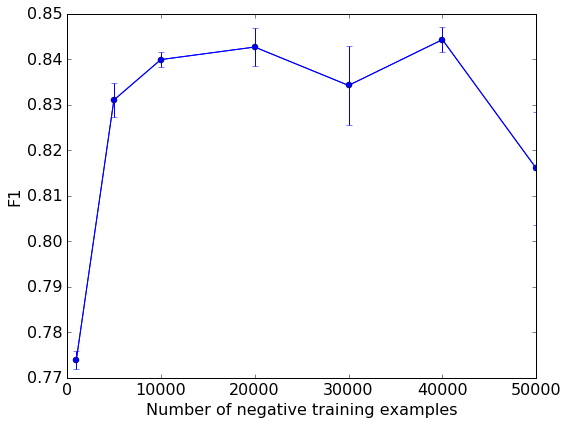

In [23]:
def plot_f1_v_nneg(results):
    """ Plot Figure 3"""
    nnegs = []
    f1s = []
    ses = []
    for i, r in results.iterrows():
        if type(r['model']) == RandomNegativeSamplesThresholdInformedPrior and r['model'].threshold == 5.0:
            nnegs.append(r['model'].n_neg)
            f1s.append(r['f1'])
            ses.append(r['f1_se'])
    plt.figure(figsize=(8,6))
    vals = sorted(zip(nnegs, f1s, ses), key=lambda x: x[0])
    plt.plot([v[0] for v in vals], [v[1] for v in vals], 'bo-')
    plt.errorbar([v[0] for v in vals], [v[1] for v in vals], yerr=[v[2] for v in vals])
    plt.xlabel('Number of negative training examples', size=16)
    plt.ylabel('F1', size=16)
    plt.tight_layout()
    plt.savefig('paper/figs/nneg.pdf')
    plt.show()
    
plot_f1_v_nneg(results)
    

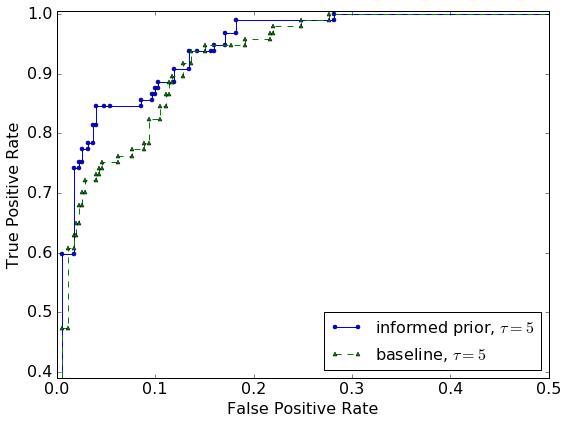

In [24]:
def plot_rocs(models, data, names):
    """
    Plot Figure 2.
    """
    truths = np.array(data.test_df['label'])    
    plt.figure(figsize=(8,6))
    formats = ['bo-', 'g^--', 'rs:']
    for model, name, fmt in zip(models, names, formats):
        probas = model.predict_proba(data)
        fpr, tpr, thresh = roc_curve(truths, probas)
        auc = roc_auc_score(truths, probas)
        plt.plot(fpr, tpr, fmt, ms=4, label='%s' % (name))
    plt.legend(loc='lower right', prop={'size':16})
    plt.xlabel('False Positive Rate', size=16)
    plt.ylabel('True Positive Rate', size=16)
    plt.xlim((0, .5))
    plt.ylim((0.39, 1.005))
    plt.tight_layout()
    plt.savefig('paper/figs/roc.pdf')
    plt.show()
    
def get_models(models, names):
    r = []
    for n in names:
        for m in models:
            if str(m) == n:
                  r.append(m)
    return r

submodels = get_models(models, ['RandNegSampThreshInfoPrior(C=1, nneg=20000, t=5.0)',
                                'RandomNegSamplesThresh(C=1, nneg=20000, t=5.0)'])
                                
plot_rocs(submodels, data, [r'informed prior, $\tau=5$', r'baseline, $\tau=5$'])

In [25]:
best_model = get_models(models, ['RandNegSampThreshInfoPrior(C=1, nneg=20000, t=5.0)'])[0]
baseline_model = get_models(models, ['RandomNegSamplesThresh(C=1, nneg=20000, t=5.0)'])[0]

In [26]:
def error_analysis_recalled_products(model, data, n):
    """
    Look at the worst reviews for the top products predicted
    to be recalled by this model.
    """
    probas = model.predict_proba_reviews(data)
    scores = model.score_asin_recalls(data, _max)
    asins = np.array(list(scores.keys()))
    found = 0
    for asin, score in sorted(scores.items(), key=lambda x: -x[1]):
        label = 1 if asin in data.recalled_asins else 0
        #if label == 0:
        print('\n\n------------\n', asin, label, score)
        idx = np.array(data.reviews_df[data.reviews_df.ASIN==asin].index.tolist())
        topi = probas[idx].argsort()[::-1][:1]
        for i in topi:
            ii = idx[i]
            print(probas[ii], data.reviews_df.iloc[ii]['reviewText'])
        found += 1
        if found >= n:
            break

error_analysis_recalled_products(best_model, data, 20)



------------
 B00115PFOO 0 1.0
1.0 How can I begin the review of this bed?  I have to say, this bed is sweet. The wooden pieces were veneered and cheap, but acceptable for a toddler, temporary bed- they look cute, at least. However, my friend and I spent an evening constructing this bed for her adorable toddler.  We nearly died in the process. First, the instructions appeared to have been translated from the original, incomprehensible language into Farsi, then French, then Yiddish, from there into Mandarin Chinese before finally being written in English.  All of the parts were listed in letter format ("Attach Side A to bar F using wooden dowels and bolt.  It is better this way"), yet none of the parts themselves had a letter, despite being plastered with warning labels.  Instead, tiny drawings on the instructions labeled the parts.  It was up to you to sort and translate.  This seemed like not a huge deal at first, but like the horror movie in which the innocent girl finds the latch 

B00499DRY4 1 -111 -111
B001VNCVSO 1 -993 -993
B001UHNKMM 1 -627 -627
B0028K2RNI 1 32 32
B0000AQZXM 1 -1730 -1730
B00155UGTO 2 -1227 -791
B001H0GGJG 1 -37 -37
B000325T8S 2 47 200
B00DHINGB2 4 -797 -618
B000XHUHMG 1 -496 -496
B000096RDO 2 -3203 -3121
B003VIIUDW 1 339 339
B0009UBSFM 4 -2232 -974
B000J2DQPA 1 -760 -760
B0026L7D0G 2 -330 323
B00166LX9Y 2 343 636
B001N44UVW 5 36 712
B0002E7DHW 6 -977 98
B00004D3EU 25 -1365 477
B001D62PYE 3 -121 1595
B000324Y7U 29 -2508 -344
B005OOKOK8 3 -26 714
B000056C86 5 2565 3680
B00030HRQM 2 -2268 -1910
B004B762AK 11 346 1201
B000K0QZY0 4 -136 85
B00C870102 1 81 81
B0007GDOF0 2 -1130 -1053
B00007C65S 1 -117 -117
B00318CLA0 2 -1028 -828
B0035ER8MG 1 -59 -59
B0002JZOLO 1 -511 -511
B002M6PPTQ 1 35 35
B000ZMT6VM 3 132 839
B0028K2RMO 1 -381 -381
B001870Z9K 1 -591 -591
B001N44UVC 3 -494 714
B008K0TLJ8 1 -615 -615
B007S76KSE 2 -1126 -758
B002R26LZM 7 -873 588
B0087UUKHI 1 -730 -730
B00020V5A2 4 -311 330
B0035ER8KS 8 -63 1056
B001NAATW0 8 -422 505
B00GSNFDQ4 2 

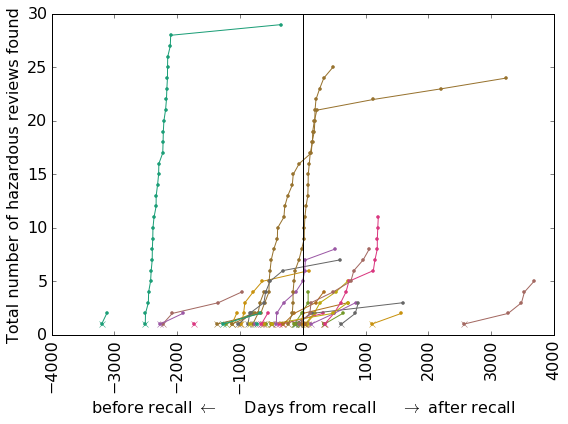

found early warning for 39/86 (0.45) product recalls
earliest day: mean=-328.97, median=-136.50
204 / 7318 reviews classified as positive
204 total time diffs


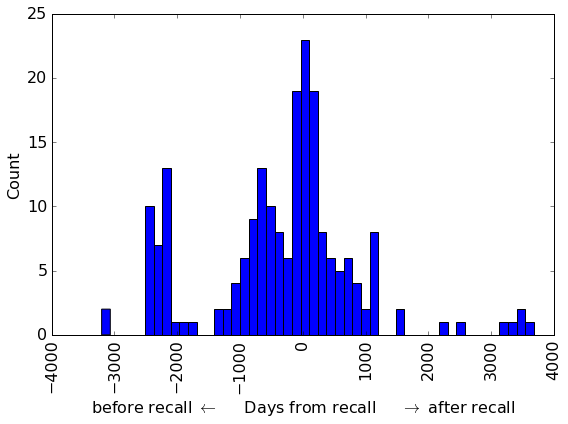

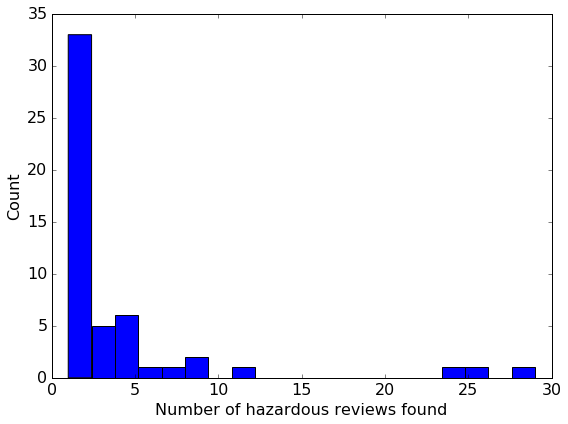

In [27]:
# Plot Figures 4 and 5.

def get_reviews_before_date(data, asin, date):
    reviews = data.reviews_df[data.reviews_df.ASIN==asin].sort_values('review_time')
    return reviews
    
def time_diff(time1, time2):
    """
    time2 - time1
    time2 2012-01-02T00:00:00
    time1 2011-11-03
    """
    return (datetime.strptime(time2[:10], '%Y-%m-%d') - datetime.strptime(time1, '%Y-%m-%d')).days
    
def get_colors():
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in np.linspace(0, 1, 10)]
    return cycle(colors)
    
def predict_by_time(model, data):
    recalls_df = data.recalls_df[data.recalls_df.label==1]
    probas = model.predict_proba_reviews(data)
    found = 0
    correct = 0
    plt.figure(figsize=(8,6))
    colors = get_colors()
    all_diffs = []
    n_pos = []
    total_reviews = 0
    total_pos = 0
    total_time_diffs = 0
    for asin in data.recalled_asins:
        recall = recalls_df[recalls_df.AmazonAsin==asin].iloc[0]
        reviews = get_reviews_before_date(data, asin, recall['RecallDate'])
        if (len(reviews) > 9): # only consider products with at least 10 reviews.
            found += 1
            total_reviews += len(reviews)
            idx = np.array(reviews.index.tolist())
            vals = probas[idx]
            pos_idx = np.where(vals >= 0.5)[0]
            total_pos += len(pos_idx)
            if asin == 'XXXX':   # For manual analysis of recall reviews
                print(recall['RecallName'])
                print(recall['RecallDescription'])
                print(recall['RecallDate'])
                print(recall['RecallTitle'])
                print('\n'.join('%s %s' % (x,y) for x,y in 
                                zip(reviews.iloc[pos_idx]['review_time'],
                                    reviews.iloc[pos_idx]['reviewText'])))
            if len(pos_idx) > 0:
                n_pos.append(len(pos_idx))
                color = next(colors)
                times = reviews.iloc[pos_idx]['review_time']
                time_diffs = [-time_diff(t, recall['RecallDate']) for t in times]
                if len(time_diffs) > 0:  # found recall review within 500 days of recall (before/after)
                    all_diffs.extend(time_diffs)
                    if time_diffs[0] < 0: # found before recall
                        correct += 1
                    counts = np.arange(len(time_diffs)) + 1
                    plt.plot(time_diffs, counts, '.-', color=color)
                    plt.plot(time_diffs[0], 1, 'x', ms=6, color=color)
                    total_time_diffs += len(time_diffs)
                    print(asin, len(pos_idx), time_diffs[0], time_diffs[-1])                        
    plt.xticks(rotation=90)
    plt.axvline(x=0, color='k')
    plt.ylabel('Total number of hazardous reviews found', size=16)
    plt.xlabel(r'before recall $\leftarrow$     Days from recall     $\rightarrow$ after recall', size=16)
    plt.tight_layout()
    plt.savefig('paper/figs/leadtime.pdf')
    plt.show()
    print('found early warning for %d/%d (%.2f) product recalls' % (correct, found, correct/found))
    print('earliest day: mean=%.2f, median=%.2f' % (np.mean(all_diffs), np.median(all_diffs)))
    print('%d / %d reviews classified as positive' % (total_pos, total_reviews))
    print('%d total time diffs' % total_time_diffs)

    plt.figure(figsize=(8,6))
    plt.hist(all_diffs, bins=50)
    plt.xticks(rotation=90)
    plt.ylabel('Count', size=16)
    plt.xlabel(r'before recall $\leftarrow$     Days from recall     $\rightarrow$ after recall', size=16)
    plt.tight_layout()
    plt.savefig('paper/figs/dayshist.pdf')
    plt.show()

    plt.figure(figsize=(8,6))
    plt.hist(n_pos, bins=20)
    plt.ylabel('Count', size=16)
    plt.xlabel('Number of hazardous reviews found', size=16)
    plt.tight_layout()
    plt.savefig('paper/figs/counthist.pdf')
    plt.show()

predict_by_time(best_model, data)

recalled mean=3.77332
not recalled mean=4.12057


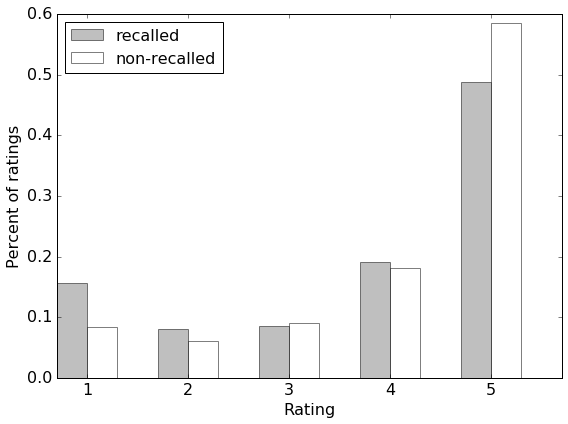

In [28]:
# Plot review distribution for recalled vs non-recalled (Figure 1).
def plot_review_dist(data):
    recalled = []
    nonrecalled = []
    for r in data.reviews_df.iterrows():
        if r[1].ASIN in data.recalled_asins:
            recalled.append(r[1].review_score)
        else:
            nonrecalled.append(r[1].review_score)
    print('recalled mean=%g' % np.mean(recalled))
    print('not recalled mean=%g' % np.mean(nonrecalled))

    plt.figure(figsize=(8,6))
    recalled_ct = Counter(recalled)
    nonrecalled_ct = Counter(nonrecalled)
    ratings = np.arange(5) + 1
    bar_width = .3
    plt.bar(ratings, [recalled_ct[r] / len(recalled) for r in ratings],
            bar_width, alpha=.5, color='grey', label='recalled')
    plt.bar(ratings + bar_width, [nonrecalled_ct[r] / len(nonrecalled) for r in ratings],
            bar_width, alpha=.5, color='w', label='non-recalled')
    plt.xticks(ratings + bar_width, ratings)
    #plt.hist(recalled, alpha=.5, normed=True, label='recalled')
    #plt.hist(nonrecalled, alpha=.5, normed=True, label='not recalled')
    plt.legend(loc='best', prop={'size':16})
    plt.ylabel('Percent of ratings', size=16)
    plt.xlabel('Rating', size=16)
    #plt.title('Rating distribution for recalled vs. non-recalled products', size=14)
    plt.tight_layout()
    plt.savefig('paper/figs/ratings.pdf')
    plt.show()
    
plot_review_dist(data)
    

Counter({0: 7356, 1: 214})
Counter({0: 897233, 1: 10643})
recalled pct pos=0.0282695
nonrecalled pct pos=0.011723


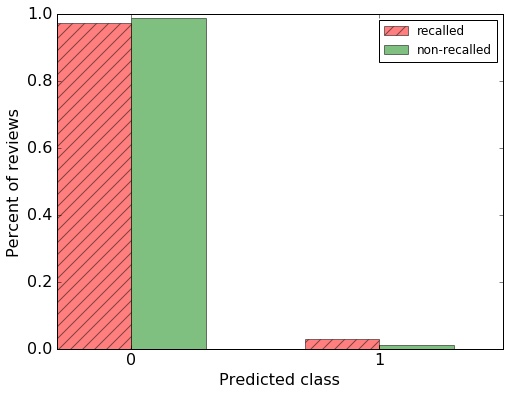

Counter({0: 7343, 1: 227})
Counter({0: 897126, 1: 10750})
recalled pct pos=0.0299868
nonrecalled pct pos=0.0118408


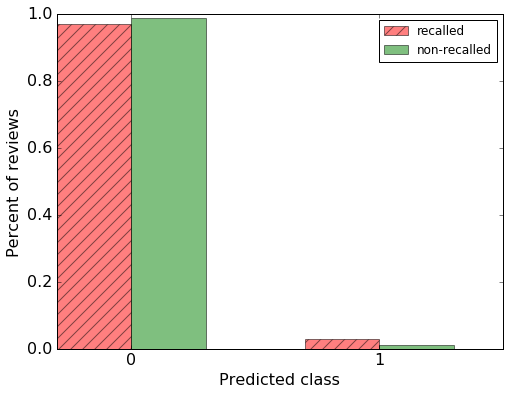

In [29]:
# Plot distribution of recall reviews for recalled vs non-recalled
def plot_recall_dist(data, model):
    recalled = []
    nonrecalled = []
    preds = model.predict_reviews(data)
    for r in data.reviews_df.iterrows():
        if r[1].ASIN in data.recalled_asins:
            recalled.append(preds[r[0]])
        else:
            nonrecalled.append(preds[r[0]])
    plt.figure(figsize=(8,6))
    recalled_ct = Counter(recalled)
    nonrecalled_ct = Counter(nonrecalled)
    print(recalled_ct)
    print(nonrecalled_ct)
    print('recalled pct pos=%g' % (recalled_ct[1] / len(recalled)))
    print('nonrecalled pct pos=%g' % (nonrecalled_ct[1] / len(nonrecalled)))    
    ratings = np.arange(2)
    bar_width = .3
    plt.bar(ratings, [recalled_ct[r] / len(recalled) for r in ratings],
            bar_width, alpha=.5, color='r', label='recalled', hatch="//")
    plt.bar(ratings + bar_width, [nonrecalled_ct[r] / len(nonrecalled) for r in ratings],
            bar_width, alpha=.5, color='g', label='non-recalled')
    plt.xticks(ratings + bar_width, ratings)
    plt.legend(loc='best')
    plt.ylabel('Percent of reviews', size=16)
    plt.xlabel('Predicted class', size=16)
    plt.show()
    
plot_recall_dist(data, best_model)
plot_recall_dist(data, baseline_model)

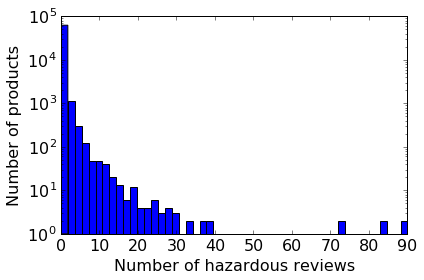

In [30]:
# Plot Figure 6.
asin2recall_score = best_model.score_asin_recalls(data)
plt.figure()
plt.hist(sorted(asin2recall_score.values()), bins=50, bottom=1)
plt.yscale('log')
plt.xlabel('Number of hazardous reviews', size=16)
plt.ylabel('Number of products', size=16)
plt.tight_layout()
plt.savefig('paper/figs/pred_ratings.pdf')
plt.show()

In [31]:
Counter(asin2recall_score.values()).most_common(10)

[(0, 59362),
 (1, 3285),
 (2, 778),
 (3, 374),
 (4, 190),
 (5, 113),
 (6, 63),
 (7, 57),
 (8, 46),
 (9, 29)]

In [32]:
# Print top coef for inclusion in Table 4.
def print_coef_table(models, data):
    submodels = get_models(models, ['RandNegSampThreshInfoPrior(C=1, nneg=20000, t=5.0)',
                                    'RandomNegSamplesThresh(C=1, nneg=20000, t=5.0)'])  
    coef = submodels[0].clf.coef_[0] * submodels[0].transform[0,:].toarray()[0]
    coef2 = submodels[1].clf.coef_[0]
    terms1 = data.vec.features[np.argsort(coef)[::-1][:20]]
    terms2 = data.vec.features[np.argsort(coef2)[::-1][:20]]
    print('in informed prior, but not baseline:', set(terms1) - set(terms2))
    print('in baseline prior, but not informed prior:', set(terms2) - set(terms1))

    print('informed prior:')
    print(', '.join(terms1))
    print('baseline:')
    print(', '.join(terms2))

    scaled = scale(coef)
    scaled2 = scale(coef2)
    
    diff = scaled2 - scaled
    print('\n\n')
    for i in np.argsort(diff)[::-1][:20]:
        print(data.vec.features[i], diff[i], coef2[i], coef[i], scaled2[i], scaled[i])
    print('\n\n')
    for i in np.argsort(diff)[:20]:
        print(data.vec.features[i], diff[i], coef2[i], coef[i], scaled2[i], scaled[i])
    
print_coef_table(models, data)

in informed prior, but not baseline: {'burnt', 'leaned forward', 'was chewing', 'was playing', 'got stuck', 'was hanging', 'very dangerous', 'swallow it', 'snapped', 'smacked', 'cpsc', 'recalled', 'the consumer', 'emergency room', 'is unsafe', 'injured', 'exploded'}
in baseline prior, but not informed prior: {'fell', 'rash', 'light', 'caused', 'noticed', 'pampers', 'choking', 'rock', 'night light', 'unsafe', 'stuck', 'broke', 'crib', 'dangerous', 'model', 'happened', 'gate'}
informed prior:
very dangerous, cpsc, mold, smacked, swallow it, emergency room, recalled, recall, was playing, hazard, is unsafe, snapped, leaned forward, the consumer, got stuck, was hanging, burnt, injured, exploded, was chewing
baseline:
mold, pampers, fell, crib, rock, dangerous, night light, hazard, broke, happened, gate, rash, light, recall, model, stuck, unsafe, caused, noticed, choking



dangerous the 39.3137994843 0.0341056623672 -5.04980244726 0.764773373732 -38.5490261105
have happened 26.1050187427 0.

In [33]:
def print_chi2_predicted(model, data, n_feats=100):
    preds = model.predict_reviews(data) # model.clf.predict(data.X_reviews)
    nneg = len(np.where(preds==0)[0])
    npos = len(np.where(preds==1)[0])
    print(Counter(preds))
    chi, _ = chi2(data.X_reviews, preds)
    chi = np.nan_to_num(chi)
    # restrict to positive features
    ppos_counts = data.X_reviews[np.where(preds==1)].sum(axis=0).A1
    pneg_counts = data.X_reviews[np.where(preds==0)].sum(axis=0).A1
    chi_pos = chi * np.array([1 if c > 0 else 0 for c in model.clf.coef_[0]])
    print('RECALL TERMS')
    terms = []
    for i in np.argsort(chi_pos)[::-1][:n_feats]:
        terms.append({'feature': data.vec.features[i],
                      'chi2': '%.1f' % chi_pos[i],
                      'coef': '%.2f' % model.clf.coef_[0][i],
                      'pos_count': ppos_counts[i],
                      'pos_frac': '%.3f' % (ppos_counts[i]/npos),
                      'neg_count': pneg_counts[i],
                      'neg_frac': '%.3f' % (pneg_counts[i]/nneg)})
    display(pd.DataFrame(terms))

    print('\n\nNON-RECALL TERMS')
    chi_neg = chi * np.array([1 if c < 0 else 0 for c in model.clf.coef_[0]])
    terms = []
    for i in np.argsort(chi_neg)[::-1][:n_feats]:
        terms.append({'feature': data.vec.features[i],
                      'chi2': '%.1f' % chi_neg[i],
                      'coef': '%.2f' % model.clf.coef_[0][i],
                      'pos_count': ppos_counts[i],
                      'pos_frac': '%.3f' % (ppos_counts[i]/npos),
                      'neg_count': pneg_counts[i],
                      'neg_frac': '%.3f' % (pneg_counts[i]/nneg)})
    display(pd.DataFrame(terms))


Evaluator(data).top_terms(best_model, n=50)
print('\n\n')
print_chi2_predicted(best_model, data, n_feats=50)



TOP FEATURES:

CLASS 0
great	1.336
this	1.299
these	0.986
for	0.980
love	0.975
loves	0.885
so	0.833
it	0.788
good	0.723
but	0.713
easy	0.697
is	0.615
well	0.612
you	0.609
are	0.604
easy to	0.602
they	0.598
and	0.593
very	0.579
perfect	0.576
to	0.533
don	0.514
with	0.509
recommend	0.493
cute	0.458
works	0.455
one	0.454
like	0.453
nice	0.443
really	0.435
as	0.434
our	0.430
soft	0.421
best	0.417
just	0.411
too	0.404
loved	0.404
them	0.401
much	0.401
all	0.388
other	0.376
use	0.371
car	0.369
can	0.368
my	0.365
what	0.359
the	0.353
buy	0.344
ve	0.341
would	0.341

CLASS 1
pampers	1.104
mold	1.006
rash	0.832
burn	0.715
snapped	0.698
allowing the	0.671
gate with	0.664
be tightened	0.660
night light	0.639
smacked	0.626
died	0.617
delta	0.599
model	0.595
that side	0.580
collapsed	0.564
crib	0.561
burnt	0.558
blisters	0.558
broke	0.553
swallow it	0.544
tightened	0.537
exploded	0.537
flipped	0.525
nap nanny	0.525
approved	0.524
attached	0.514
chemical	0.508
fire	0.507
stairway	0.505
disintegrate

,chi2,coef,feature,neg_count,neg_frac,pos_count,pos_frac
0,33099.1,0.40,hazard,1643,0.002,1055,0.097
1,31683.4,0.22,recalled,290,0.000,578,0.053
2,28377.6,0.24,dangerous,1996,0.002,1041,0.096
3,24130.7,0.55,broke,9583,0.011,1942,0.179
4,23099.4,0.45,very dangerous,43,0.000,316,0.029
5,19591.1,0.44,happened,4142,0.005,1167,0.107
6,16880.7,0.35,recall,571,0.001,465,0.043
7,16348.7,0.40,unsafe,1087,0.001,586,0.054
8,16187.7,0.05,choking hazard,599,0.001,461,0.042
9,15014.5,0.39,fell,7916,0.009,1390,0.128




NON-RECALL TERMS


,chi2,coef,feature,neg_count,neg_frac,pos_count,pos_frac
0,5443.6,-0.01,safety commission,6,0.000,71,0.007
1,4721.2,-0.00,consumer product,16,0.000,70,0.006
2,4136.3,-0.01,fell off,1457,0.002,314,0.029
3,3725.3,-0.08,customer,10366,0.011,832,0.077
4,3495.3,-0.03,customer service,8309,0.009,715,0.066
5,3234.7,-0.08,could,77816,0.086,2702,0.249
6,3116.9,-0.14,after,104963,0.116,3272,0.301
7,3072.2,-0.05,service,10748,0.012,781,0.072
8,3064.7,-0.04,had,177275,0.196,4715,0.434
9,2808.5,-0.00,recall on,66,0.000,68,0.006


In [34]:
def get_class_discrepancy(model, data, n):
    """
    For each of the top n features in the positive class, get the class distribution
    in the training data, and the predicted class distribution in the testing data.
    """
    coef = model.get_coef()[0]
    top_coef_ind = np.argsort(coef)[::-1]  # [:n]
    preds = model.predict_reviews(data)  # model.clf.predict(data.X_reviews)
    nneg = len(np.where(preds==0)[0])
    npos = len(np.where(preds==1)[0])
    # restrict to positive features
    ppos_counts = data.X_reviews[np.where(preds==1)].sum(axis=0).A1
    pneg_counts = data.X_reviews[np.where(preds==0)].sum(axis=0).A1
    
    train_pos = data.X_complaints.sum(axis=0).A1
    train_neg = data.X_reviews[model.neg_sample_idx].sum(axis=0).A1
    results = []
    count = 0
    for i in top_coef_ind:
        if train_pos[i] > 2:
            train_pr = train_pos[i] / (train_pos[i] + train_neg[i])
            test_pr = ppos_counts[i] / (ppos_counts[i] + pneg_counts[i])
            results.append(
                {
                    'term': data.vec.features[i],
                    'coef': coef[i],
                    'pr_pos_train': train_pr,
                    'pr_pos_test': test_pr,
                    'n_pos_train': train_pos[i],
                    'n_pos_test': ppos_counts[i],
                    'diff': train_pr - test_pr
                }
            )
            count += 1
        if count >= n:
            break
    pd.set_option('display.max_rows', 1000)
    #return pd.DataFrame(results).sort_values('diff', ascending=False)
    #return pd.DataFrame(results).sort_values('coef', ascending=False)
    return pd.DataFrame(results).sort_values('pr_pos_test', ascending=False)

get_class_discrepancy(baseline_model, data, 100)

,coef,diff,n_pos_test,n_pos_train,pr_pos_test,pr_pos_train,term
20,0.909811,0.571478,322,131,0.370968,0.942446,recalled
81,0.552103,0.676271,105,31,0.292479,0.968750,very dangerous
90,0.524554,0.753390,88,161,0.240437,0.993827,the consumer
13,1.007839,0.705103,235,178,0.226834,0.931937,recall
78,0.563890,0.756768,66,86,0.209524,0.966292,was playing
7,1.198926,0.696901,535,205,0.198295,0.895197,hazard
5,1.278500,0.569231,560,104,0.184392,0.753623,dangerous
79,0.558286,0.754362,124,120,0.161669,0.916031,injury
16,0.978184,0.669801,255,111,0.152421,0.822222,unsafe
19,0.962189,0.626890,349,131,0.148258,0.775148,choking


In [35]:
get_class_discrepancy(best_model, data, 100)

,coef,diff,n_pos_test,n_pos_train,pr_pos_test,pr_pos_train,term
35,0.454837,0.088527,316,31,0.880223,0.968750,very dangerous
72,0.354745,0.483095,465,178,0.448842,0.931937,recall
48,0.398166,0.504166,1055,205,0.391030,0.895197,hazard
53,0.390238,0.623188,78,10,0.376812,1.000000,dangerous to
59,0.379280,0.601716,180,45,0.355731,0.957447,got stuck
46,0.403533,0.471953,586,111,0.350269,0.822222,unsafe
86,0.338274,0.569225,266,120,0.346806,0.916031,injury
61,0.376972,0.626610,107,86,0.339683,0.966292,was playing
54,0.389196,0.549368,65,20,0.320197,0.869565,was chewing
79,0.348577,0.369792,57,8,0.296875,0.666667,hazardous


In [36]:
def plot_reviews_by_year(model, data):
    """
    Plot number of pos/neg examples by year.
    """
    preds = model.predict_reviews(data)
    years = [d[:4] for d in data.reviews_df.review_time]
    year2counts = defaultdict(lambda: Counter())
    for p, y in zip(preds, years):
        year2counts[y].update([p])
    print('\n'.join('%s %f' % (str(t), t[1][1] / (t[1][0] + t[1][1])) for t in sorted(year2counts.items())))
    
plot_reviews_by_year(best_model, data)

('2000', Counter({0: 56, 1: 1})) 0.017544
('2001', Counter({0: 845, 1: 15})) 0.017442
('2002', Counter({0: 2651, 1: 41})) 0.015230
('2003', Counter({0: 4153, 1: 74})) 0.017507
('2004', Counter({0: 7909, 1: 196})) 0.024183
('2005', Counter({0: 15724, 1: 408})) 0.025291
('2006', Counter({0: 12053, 1: 278})) 0.022545
('2007', Counter({0: 16551, 1: 257})) 0.015290
('2008', Counter({0: 23735, 1: 323})) 0.013426
('2009', Counter({0: 32511, 1: 473})) 0.014340
('2010', Counter({0: 54200, 1: 874})) 0.015870
('2011', Counter({0: 98804, 1: 1377})) 0.013745
('2012', Counter({0: 135303, 1: 1807})) 0.013179
('2013', Counter({0: 299410, 1: 2840})) 0.009396
('2014', Counter({0: 200684, 1: 1893})) 0.009345


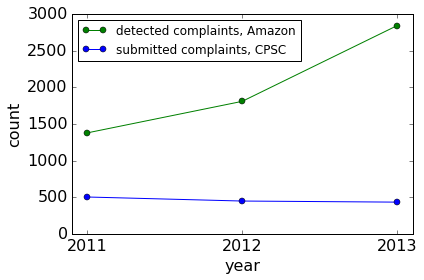

In [37]:
# Plot Figure 7.
plt.figure()
plt.plot([1377, 1807, 2840], 'go-', label='detected complaints, Amazon')
plt.plot([502, 447, 432], 'bo-', label='submitted complaints, CPSC')
plt.xticks([0, 1, 2], [2011, 2012, 2013])
plt.xlim(-.1, 2.1)
plt.legend(loc='best')
plt.xlabel('year', size=16)
plt.ylabel('count', size=16)
plt.tight_layout()
plt.savefig('paper/figs/years.pdf')
plt.show()